# 0. Setup

In [1]:
# Verify we're in the correct working directory
import os
import git 
from pathlib import Path

def get_project_root():
    return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

root = get_project_root()

os.chdir(root)
os.getcwd()

'/Users/seraphinashi/Desktop/DataFusion/DrugResponse_Omics_Molecules'

In [2]:
plot_folder = "results/images/simulations/"

## import packages, models, trainers

In [3]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

/Users/seraphinashi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


pytorch version: 1.13.1
orig num threads: 4


In [4]:
from models import *
from trainers import *
from losses import *
from utils import *

In [5]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [6]:
simu_folder = "data/simulations"
RNAseq = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq.csv"), index_col = 0)
RNAseq_meta = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq_meta.csv"), index_col = 0)
d_fp = pd.read_csv(os.path.join(simu_folder, "simu2_d_fp.csv"), index_col = 0)
# cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr.csv"), index_col = 0)
cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr_noise.csv"), index_col = 0)

In [7]:
RNAseq_meta['C_type'] = RNAseq_meta['C_type'].replace('grp3', 'grp0')

In [8]:
c_data = RNAseq.T

# originally
c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)

print(f"Cancer type coding map: ")
print(meta_map)

d_data = d_fp.T

cdr = cdr
cdr.index = cdr.index.astype("str")

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
4   grp1     1     35
8   grp2     2     41


In [9]:
num_cluster = 3

# only two groups
two_grp = True
if two_grp:
    num_cluster = 2
    RNAseq_meta.loc[RNAseq_meta.C_type=='grp2', 'C_type'] = 'grp1'
    
    c_meta_true = c_meta
    c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)
    print(f"Cancer type coding map: ")
    print(meta_map)

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
3   grp1     1     76


## Train & Test split

In [10]:
c_train, c_test = train_test_split(c_data, test_size=0.15)

c_meta_train = get_CCL_meta(c_train.index.values, c_meta)
c_meta_test = get_CCL_meta(c_test.index.values, c_meta)

cdr_train_idx = np.isin(cdr.index.values, c_train.index.values)
cdr_train = cdr[cdr_train_idx]
cdr_test = cdr[~cdr_train_idx]

if two_grp:
    c_meta_train_true = get_CCL_meta(c_train.index.values, c_meta_true)
    c_meta_test_true = get_CCL_meta(c_test.index.values, c_meta_true)

In [11]:
print(f"Training data: \n   cdr: {cdr_train.shape}\n   c_data: {c_train.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_train_true['code'], c_meta_train['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_train['code'].value_counts())

print(f"\nTesting data:  \n   cdr: {cdr_test.shape}\n   c_data: {c_test.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_test_true['code'], c_meta_test['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_test['code'].value_counts())


Training data: 
   cdr: (117, 30)
   c_data: (117, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code    0   1  Total
code                
0      54   0     54
1       0  30     30
2       0  33     33
Total  54  63    117

Testing data:  
   cdr: (21, 30)
   c_data: (21, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code   0   1  Total
code               
0      8   0      8
1      0   5      5
2      0   8      8
Total  8  13     21


# 2. Hyperparameters

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [13]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.2 #@param {type: "float"}

    n_epochs = 100 #@param {type: "integer"}
    batch_size = 50 #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    C_VAE_loss_weight = 0.1 #@param {type: "float"}
    C_recon_loss_weight = 1 #@param {type: "float"}
    C_kld_weight = 1 #@param {type: "float"}
    C_cluster_distance_weight = 200 #@param {type: "float"}
    C_update_ratio_weight = 10 #@param {type: "float"}
    
    D_VAE_loss_weight = 0.5 #@param {type: "float"}
    D_recon_loss_weight = 1.5 #@param {type: "float"}
    D_kld_weight = 1 #@param {type: "float"}
    D_cluster_distance_weight = 150 #@param {type: "float"}
    D_update_ratio_weight = 10 #@param {type: "float"}
    
    predict_loss_weight = 1500 #@param {type: "float"}
    
    cVAE_save_path = 'data/model_fits/GDSC_simu2_c_vae' #@param
    dVAE_save_path = 'data/model_fits/GDSC_simu2_d_vae' #@param
    
    c_p_save_path = 'data/model_fits/GDSC_simu2_c_vae_predictor' #@param
    d_p_save_path = 'data/model_fits/GDSC_simu2_d_vae_predictor' #@param
    

class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [64] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 16 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}
    
    # sensitive threshold
    sens_cutoff = 0.5


In [14]:
train_args = Train_Args()

K = len(c_meta['code'].unique())

CDPmodel_args = CDPModel_sub_Args()
CDPmodel_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_args['d_input_dim'] = d_data.shape[1]

if CDPmodel_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feature number not specified''')
if CDPmodel_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [15]:
CDPmodel = CDPmodel(K, CDPmodel_args)

n_rounds = 5
returns = CDPmodel.fit(c_train, c_meta_train, d_data, cdr_train, train_args, n_rounds=n_rounds, device = device)
c_meta, c_meta_hist, d_sens_hist, losses_train_hist_list, best_epos_list, C_VAE_init_losses, D_VAE_init_losses, c_latent_list, d_latent_list = returns

=> Initialize C-VAE:
        Best epoc with test loss: epoch 93
        Running time: 0.8989098072052002
=> Initialize D-VAE:
        Best epoc with test loss: epoch 71
        Running time: 0.3841078281402588
=> round 0 <==================================
------------k = 0-------------------
 - Training CDP model with k = 0
   a. Training D_VAE and Predictor
        Best epoc with test loss: epoch 8
        Running time: 29.29369616508484
   b. 10 sensitive drug(s)
   c. Training C_VAE and Predictor
        Best epoc with test loss: epoch 8
        Running time: 23.338793992996216
   d. 54 cancer cell line(s) in the cluster
------------k = 1-------------------
 - Training CDP model with k = 1
   a. Training D_VAE and Predictor
        Best epoc with test loss: epoch 6
        Running time: 36.798702001571655
   b. 10 sensitive drug(s)
   c. Training C_VAE and Predictor
        Best epoc with test loss: epoch 8
        Running time: 22.060955047607422
   d. 33 cancer cell line(s) in th

# 4. Results and visualizations

## 4.1. Prediction:

### Training data:

In [16]:
cdr_train_hat = CDPmodel.predict(c_train, d_data)

cdr_train_rslt = cdr_train.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

In [17]:
# Binary cross entropy
cdr_train_rslt_noNA = cdr_train_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_train = log_loss(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_train}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")

Binary cross entropy: 1.460665520409223
ROC AUC: 0.6871812019904188

True Positive:  1078 (93.25 %)
False Negative: 78 (6.75 %)
True Negative:  498 (23.01 %)
False Positive: 1666 (76.99 %)


<ipython-input-17-981f12712df8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)


In [18]:
cdr_train_hat.to_csv(os.path.join(simu_folder, "GDSC_simu2_cdr_hat_train.csv"), index=True)

### Testing data

In [19]:
cdr_test_hat = CDPmodel.predict(c_test, d_data, sd_scale = 6)

cdr_test_rslt = cdr_test.copy()
cdr_test_rslt['c_name'] = cdr_test_rslt.index.values
cdr_test_rslt = pd.melt(cdr_test_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_test_rslt = cdr_test_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_test_rslt = pd.merge(cdr_test_rslt, cdr_test_hat, on=['c_name', 'd_name'], how='outer')

In [20]:
cdr_test_hat['cluster'].value_counts()

cluster
 1    360
 0    210
-1     60
Name: count, dtype: int64

In [21]:
# Binary cross entropy
cdr_test_rslt_noNA = cdr_test_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_test = log_loss(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_test}")

# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
cdr_test_rslt_noNA['cdr_hat_bnr'] = (cdr_test_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")


Binary cross entropy: 1.1735756277433316
ROC AUC: 0.6903804449295551

True Positive:  176 (86.70 %)
False Negative: 27 (13.30 %)
True Negative:  138 (40.23 %)
False Positive: 205 (59.77 %)


<ipython-input-21-3e982915da35>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_test_rslt_noNA['cdr_hat_bnr'] = (cdr_test_rslt_noNA['cdr_hat'] > 0.5).astype(int)


## 4.2. Clustering
### Trainning data

In [22]:
c_meta_train_tmp = c_meta_train.loc[:, ['code']]
c_meta_train_tmp['c_name'] = c_meta_train_tmp.index.values.astype(str)
c_meta_train_tmp = c_meta_train_tmp.rename(columns={'code':'cluster_init'})

cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_train_rslt_cluster['cluster_true'], cdr_train_rslt_cluster['cluster_init']], cdr_train_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['cluster']))
    


cluster                    -1   0   1
cluster_true cluster_init            
0            0              1  53   0
1            1              0   0  30
2            1              0   0  33


In [23]:
print('Cancer clustering before:')
print(c_meta_hist.code.value_counts())
print('Cancer clustering after:')
print(c_meta_hist.code_latest.value_counts())

Cancer clustering before:
code
1    63
0    54
Name: count, dtype: int64
Cancer clustering after:
code_latest
1     63
0     53
-1     1
Name: count, dtype: int64


In [24]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_latest.value_counts())

Sensitive to clusters before:
sensitive_k
-1    13
0     10
1      7
Name: count, dtype: int64
Sensitive to clusters after:
sensitive_k_latest
0        20
0 & 1    10
Name: count, dtype: int64


### Testing data

In [25]:
c_meta_test_tmp = c_meta_test.loc[:, ['code']]
c_meta_test_tmp['c_name'] = c_meta_test_tmp.index.values.astype(str)
c_meta_test_tmp = c_meta_test_tmp.rename(columns={'code':'cluster_init'})

cdr_test_rslt_tmp = cdr_test_rslt[['c_name', 'cluster']]
cdr_test_rslt_tmp = cdr_test_rslt_tmp.drop_duplicates()
cdr_test_rslt_tmp['c_name'] = cdr_test_rslt_tmp['c_name'].astype(str)


cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_tmp, c_meta_test_tmp, on='c_name', how='left')

pd.crosstab(cdr_test_rslt_cluster['cluster_init'], cdr_test_rslt_cluster['cluster'])

cluster       -1   0   1
cluster_init            
0              2   6   0
1              0   1  12

In [26]:
if two_grp:
    cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_test_rslt_cluster['cluster_true'], cdr_test_rslt_cluster['cluster_init']], cdr_test_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_test_rslt_cluster['cluster_init'], cdr_test_rslt_cluster['cluster']))
    

cluster                    -1   0   1
cluster_true cluster_init            
0            0              2   6   0
1            1              0   1   4
2            1              0   0   8


## Visualizations

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

### Trainning data:

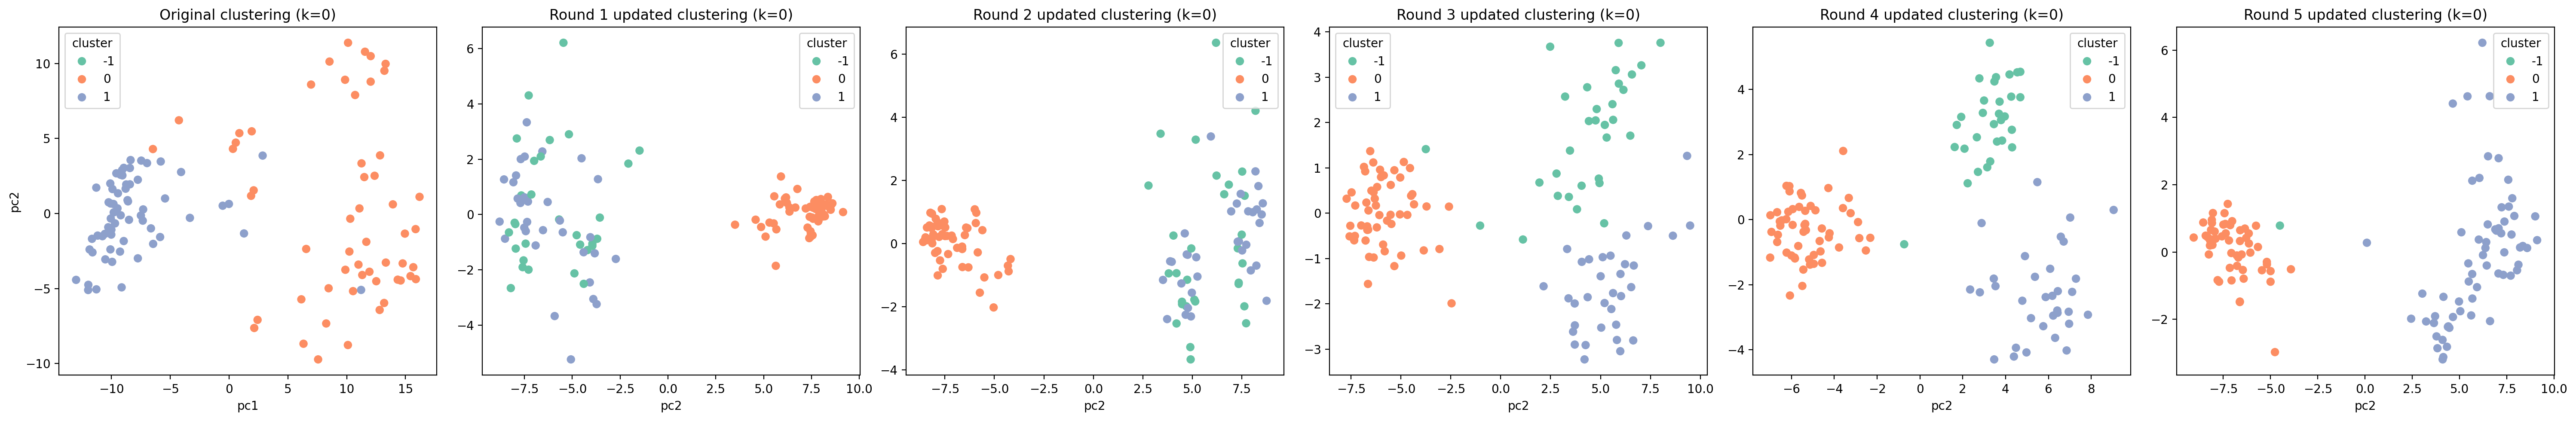

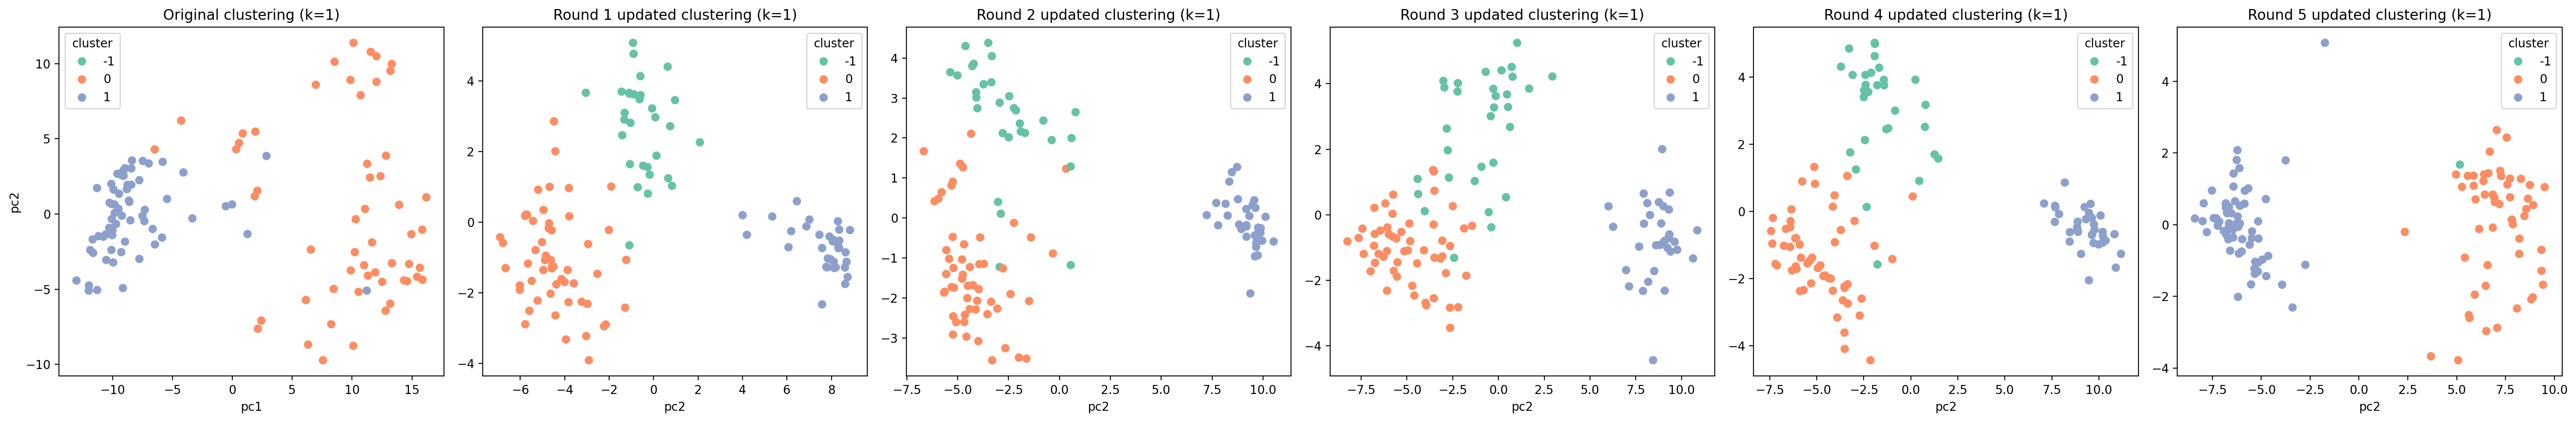

In [28]:
for k in range(K):
    plot_c_PCA_latent(c_train, c_latent_list, c_meta_hist, n_rounds, legend_title='cluster', k=k, 
                      plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_c_latent_k{k}.png')

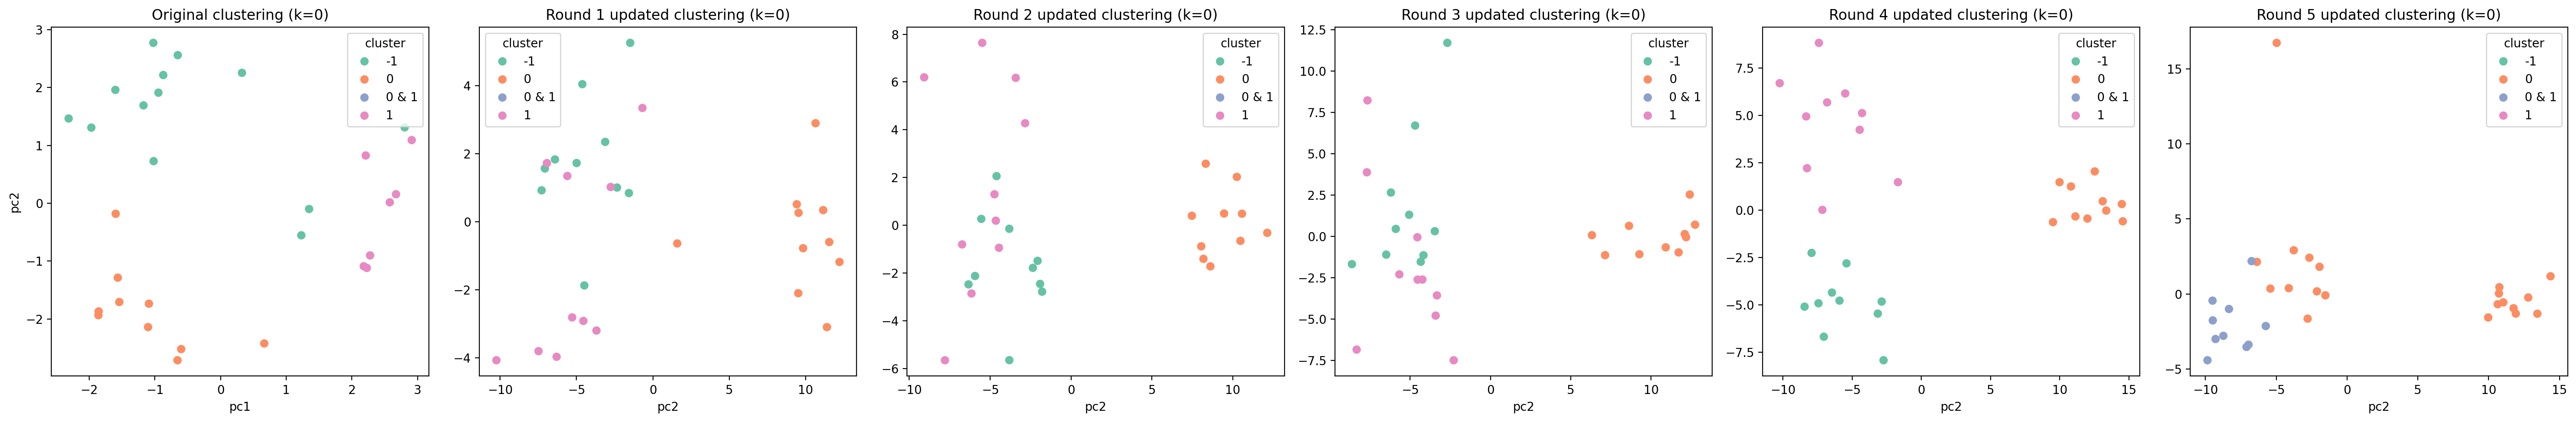

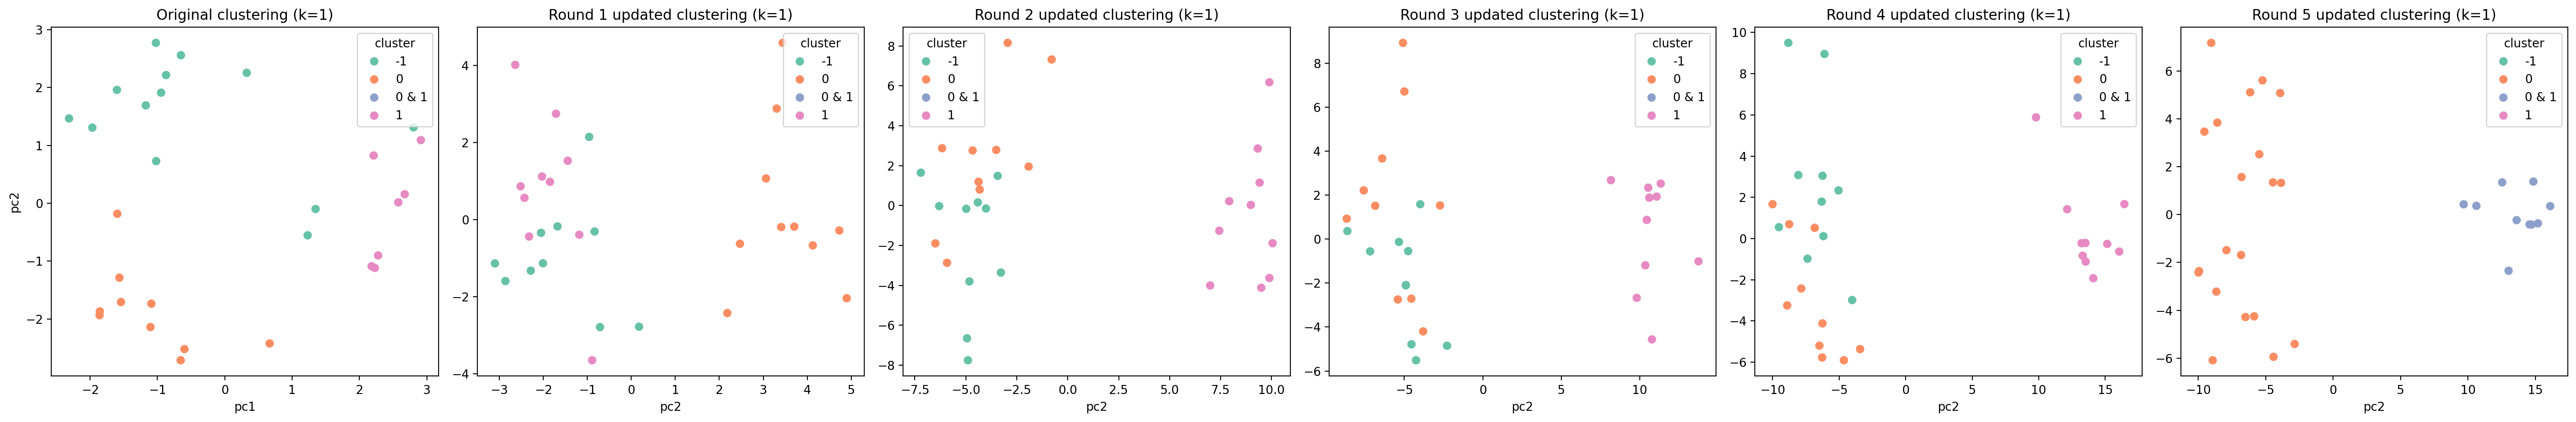

In [29]:
for k in range(K):
    plot_d_PCA_latent(d_data, d_latent_list, d_sens_hist, n_rounds, legend_title='cluster', k=k, 
                      plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_d_latent_k{k}.png')

### Adding testing data:

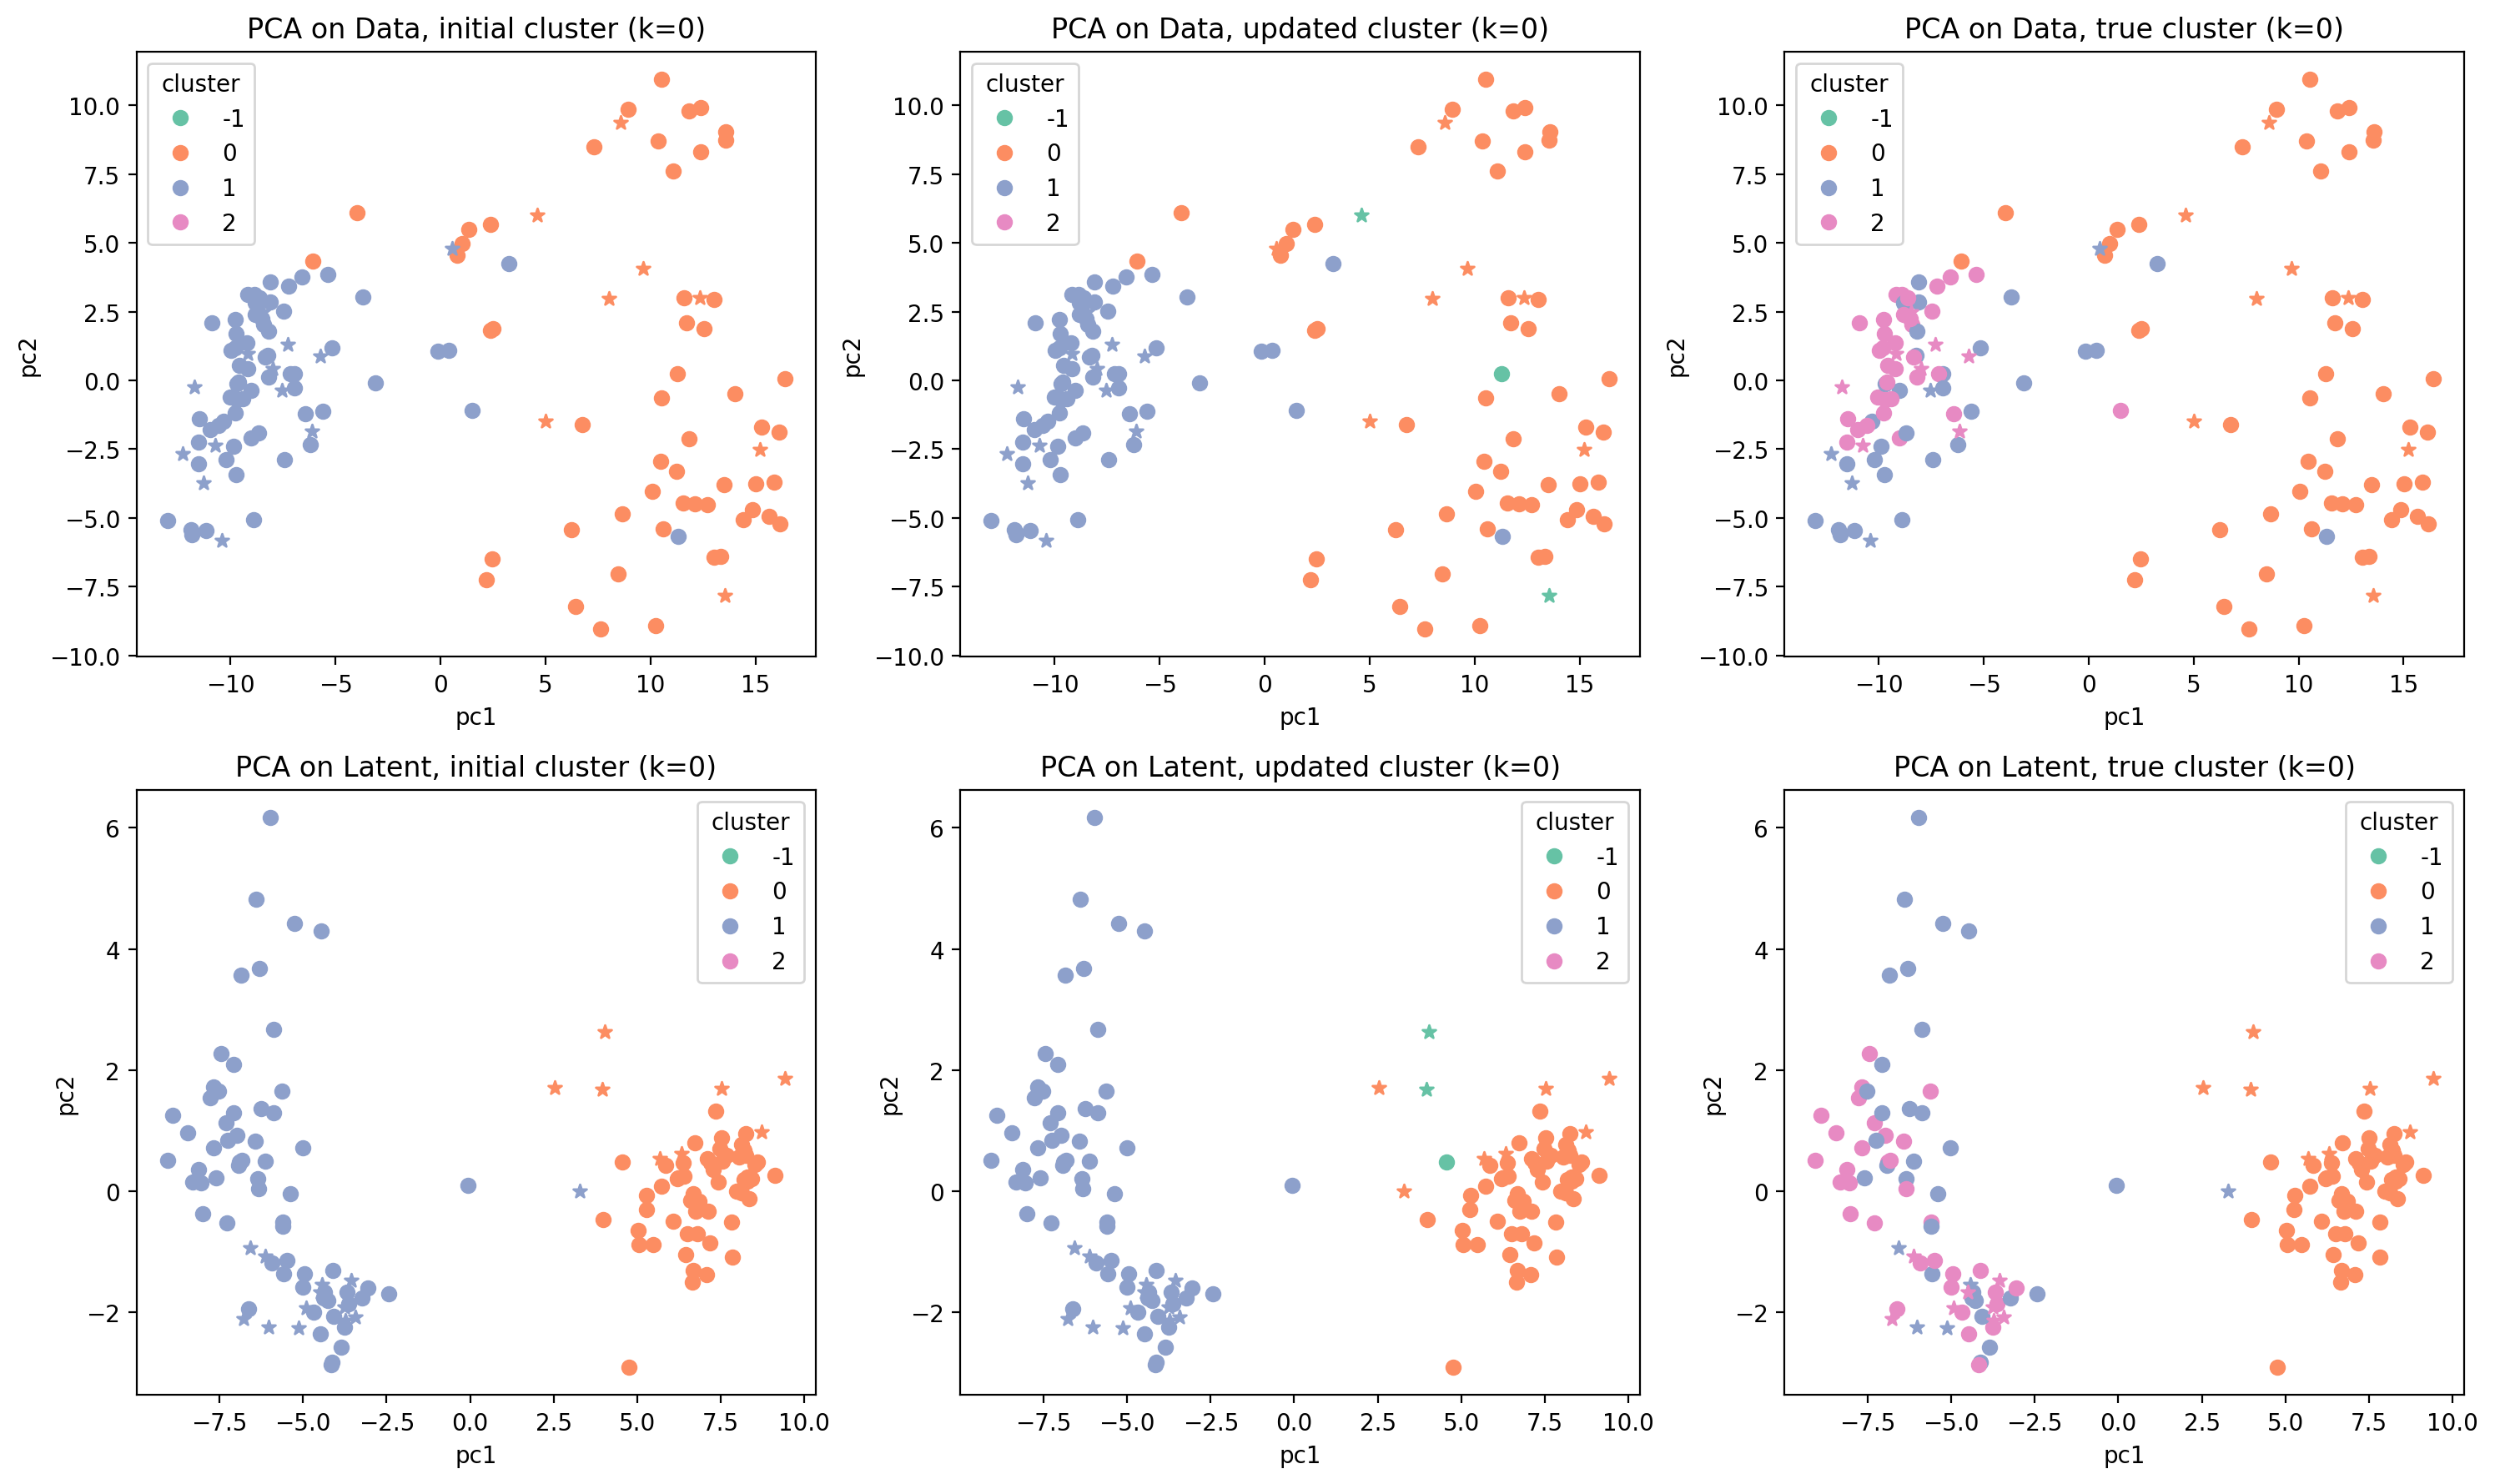

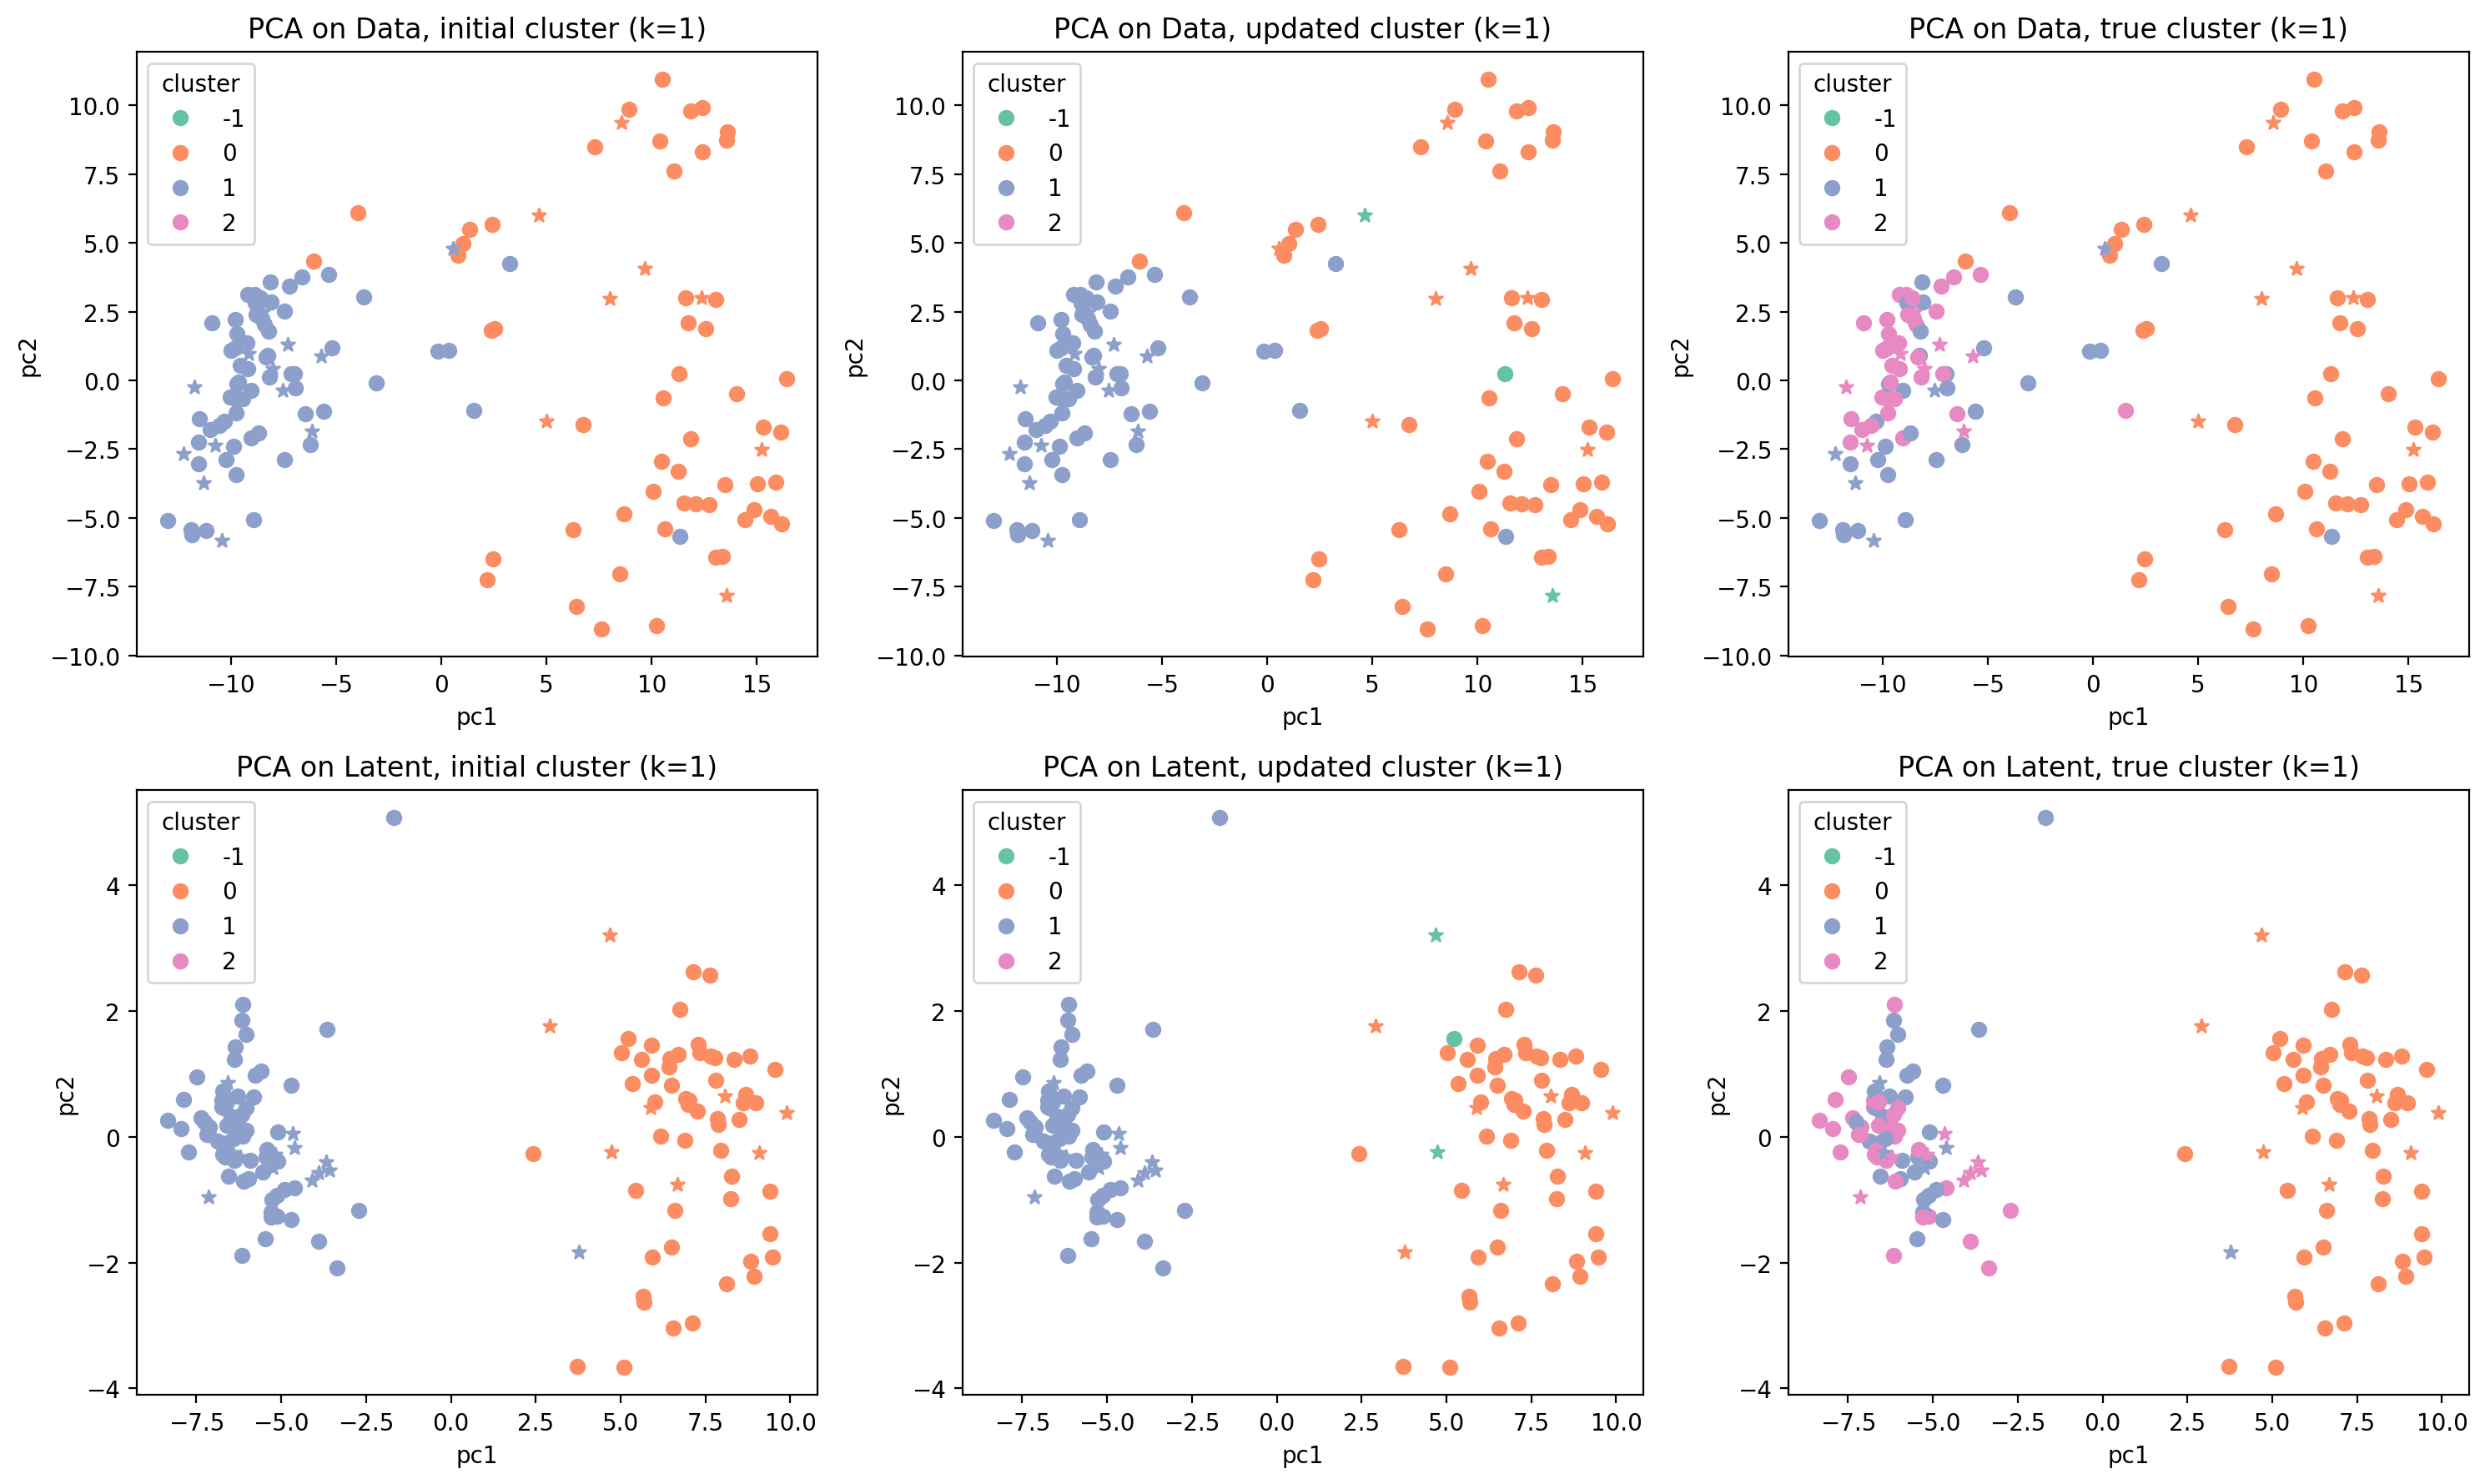

In [30]:
for k in range(K):
    plot_c_PCA_latent_test(CDPmodel, device, n_rounds, c_latent_list, c_train, c_test, cdr_train_rslt_cluster, cdr_test_rslt_cluster, k=k, 
                       plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_c_latent_k{k}_test_data.png')

### Losses:

In [31]:
losses_train_hist_list[0][0][0]

epoch  loss_train  loss_test  vae_loss_train  vae_loss_test  \
0       0   25.427163  18.294334       15.972044      10.061004   
1       1   15.753205  16.749037       10.823887       7.144682   
2       2   14.407255  15.360749        9.682633       7.064766   
3       3   14.136682  15.384711        9.279293       6.520743   
4       4   13.383076  15.538210        8.985017       6.394898   
..    ...         ...        ...             ...            ...   
95     95   11.639662  24.608715        9.176179       6.794476   
96     96   11.228353  23.125106        8.740698       6.500547   
97     97   11.812999  26.714758        9.155686       7.960704   
98     98   11.624595  60.652396        9.032965       7.888478   
99     99   12.228903  31.818176        9.736825       8.282097   

    recon_loss_train  recon_loss_test  kld_train   kld_test  \
0          16.328125        15.143009  10.065729  18.339723   
1          15.949967        14.626810  13.272198  16.365862   
2          15.412891        14.745004  13.835799  14.590674   
3          15.129598        14.184661  13.762055  14.719343   
4          14.671742        14.100062  13.799669  14.895125   
..               ...              ...        ...        ...   
95         12.492089        12.174278  13.034493  13.254048   
96         12.567085        11.924857  13.200237  12.966400   
97         12.518690        12.517960  13.837575  12.147121   
98         12.497024        11.716501  12.199439  13.756487   
99         12.382598        11.861924  12.800040  12.429169   

    latent_dist_loss_train  latent_dist_loss_test  update_overlap_train  \
0               -10.421811             -23.421729                 -7.80   
1               -18.398279             -23.847991                 -8.44   
2               -19.566058             -22.270912                 -8.20   
3               -19.612360             -22.383260                 -8.08   
4               -19.486394             -22.600290                 -8.40   
..                     ...                    ...                   ...   
95              -16.350402             -18.633850                 -8.12   
96              -17.026624             -18.390710                 -8.32   
97              -17.200578             -16.704378                 -8.32   
98              -15.663498             -17.584509                 -8.16   
99              -15.445813             -16.008996                 -8.44   

    update_overlap_test  prediction_loss_train  prediction_loss_test  
0             -7.428571               9.612378              8.400533  
1             -7.571429               5.099480              9.774773  
2             -7.571429               4.889944              8.466402  
3             -7.428571               5.020292              9.031171  
4             -7.714286               4.567414              9.316945  
..                  ...                    ...                   ...  
95            -7.571429               2.627193             17.984657  
96            -7.428571               2.655397             16.791762  
97            -7.000000               2.825055             18.911611  
98            -8.142857               2.756146             52.947196  
99            -7.714286               2.662239             23.709713  

[100 rows x 15 columns]

k = 0:
round 0:


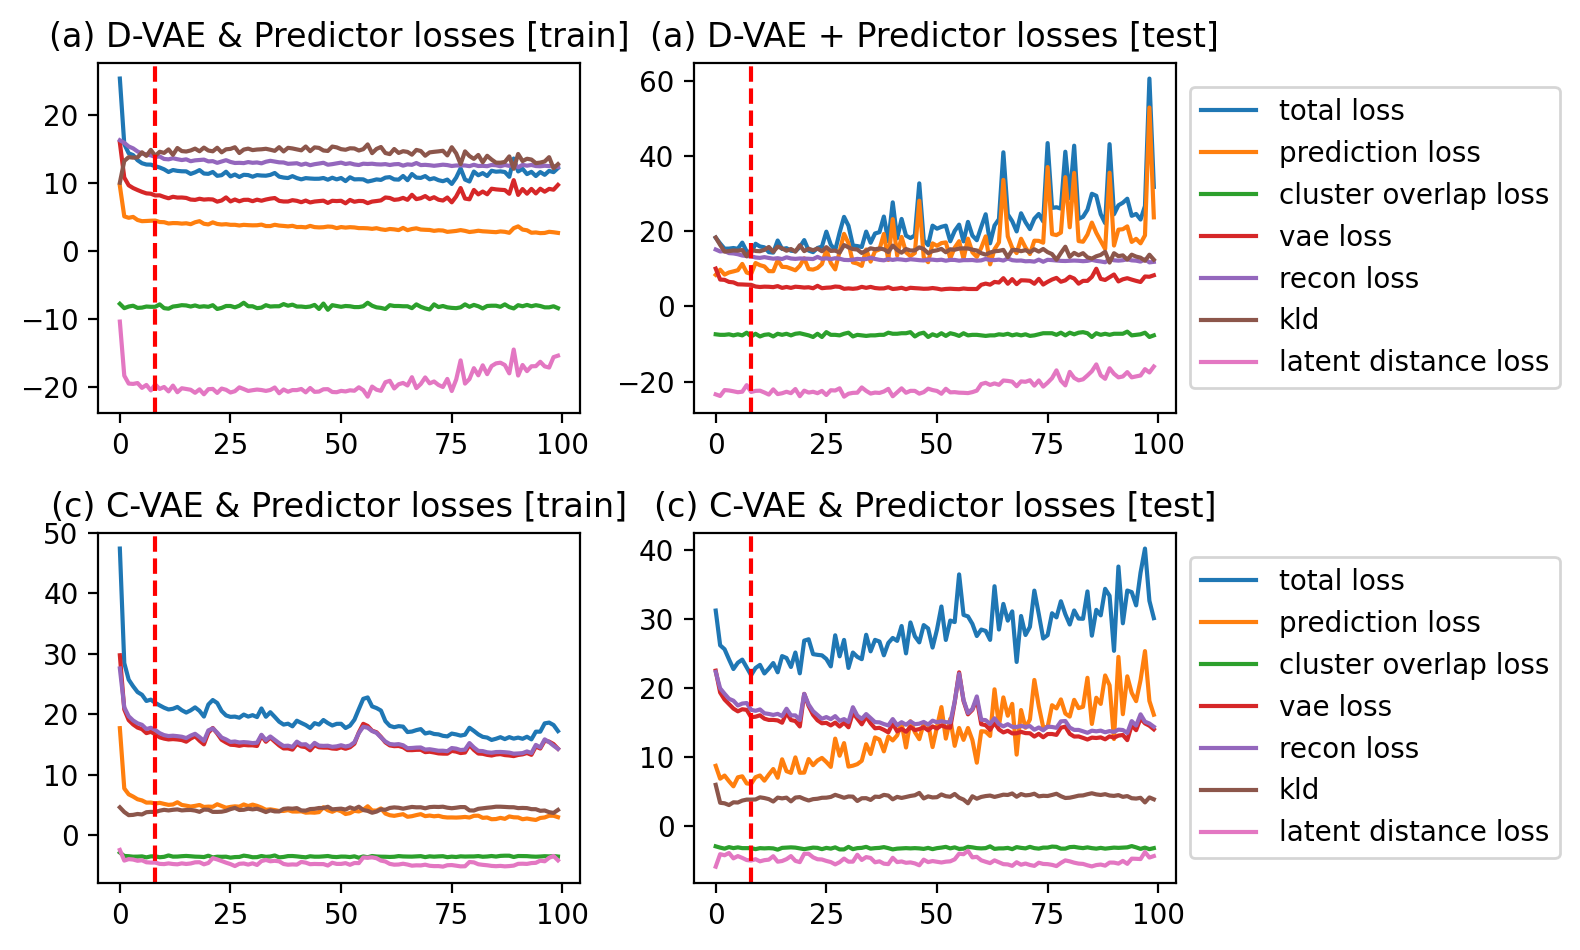

round 1:


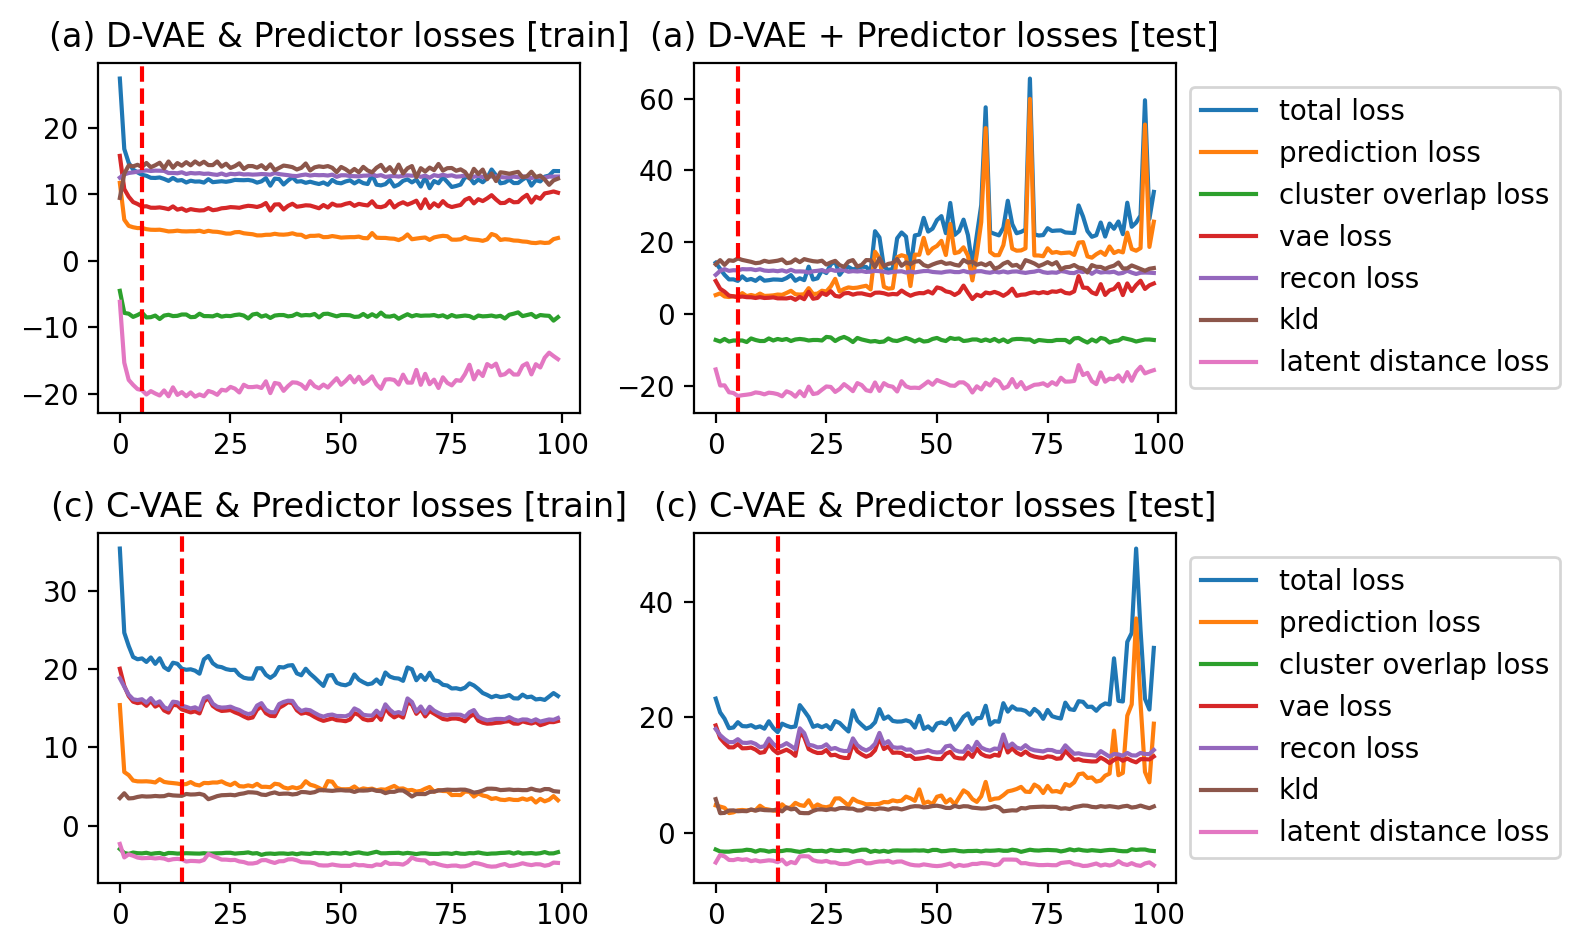

round 2:


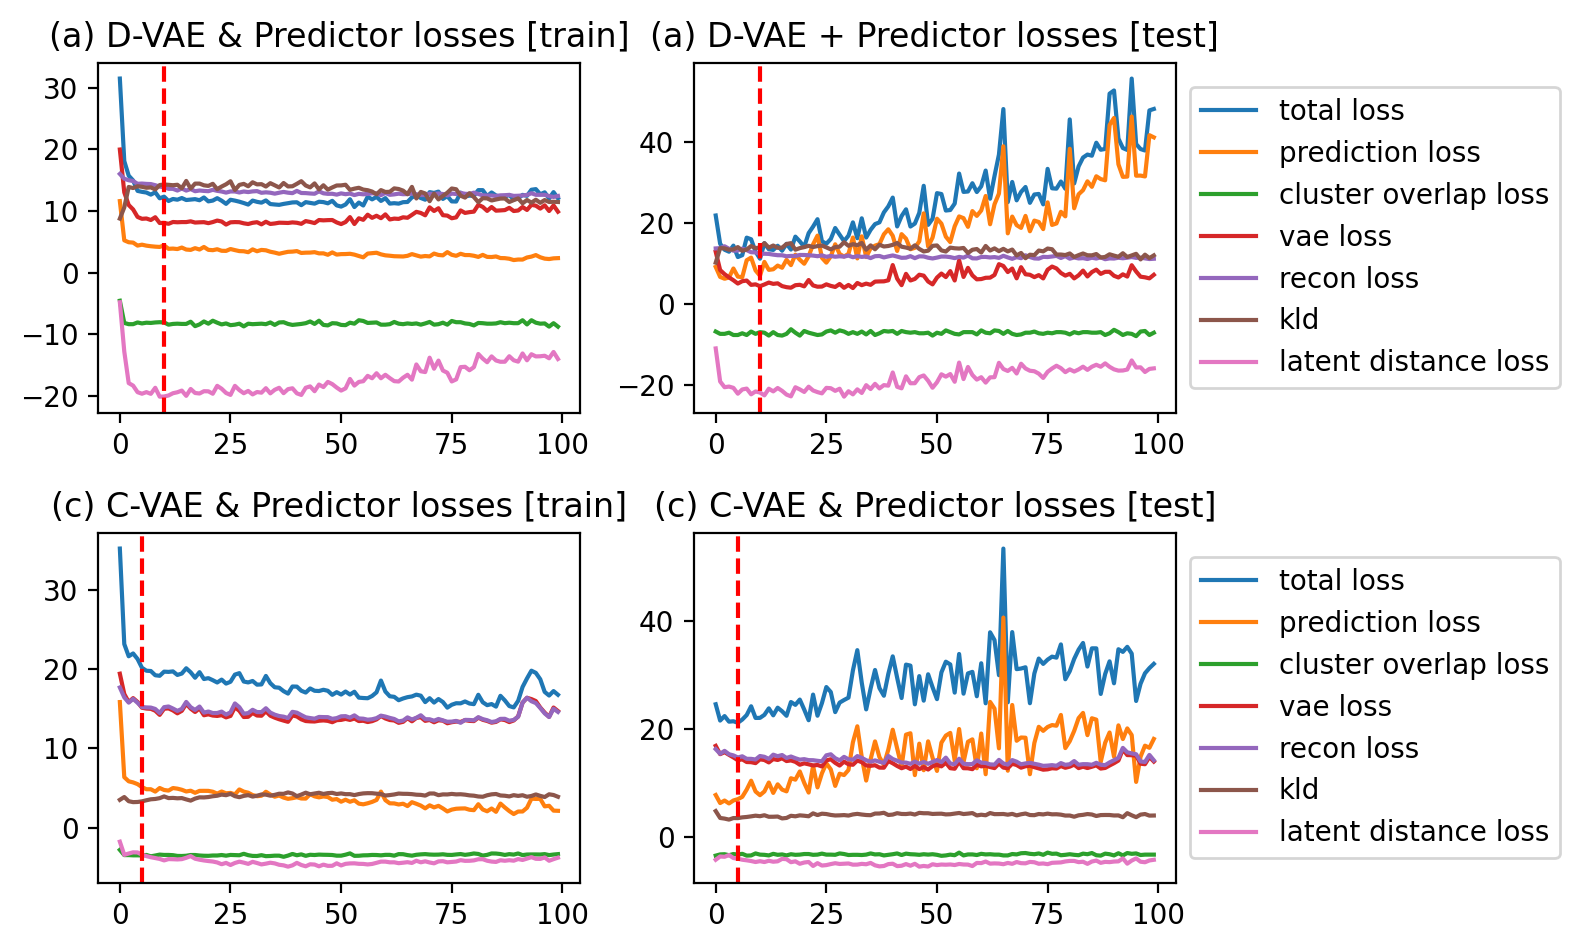

round 3:


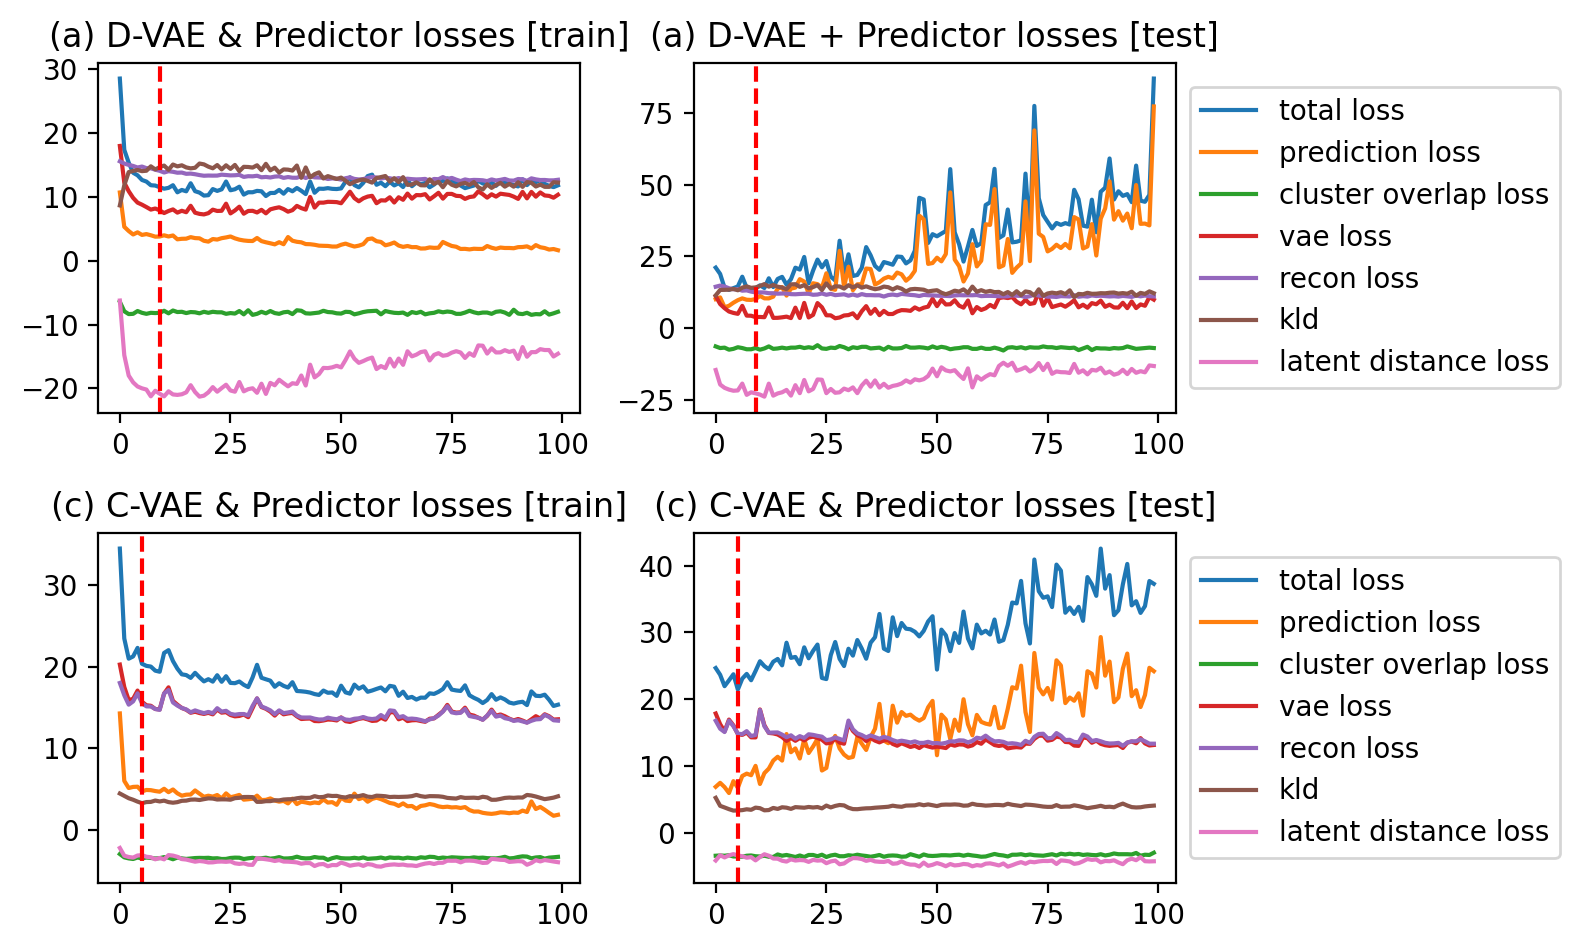

round 4:


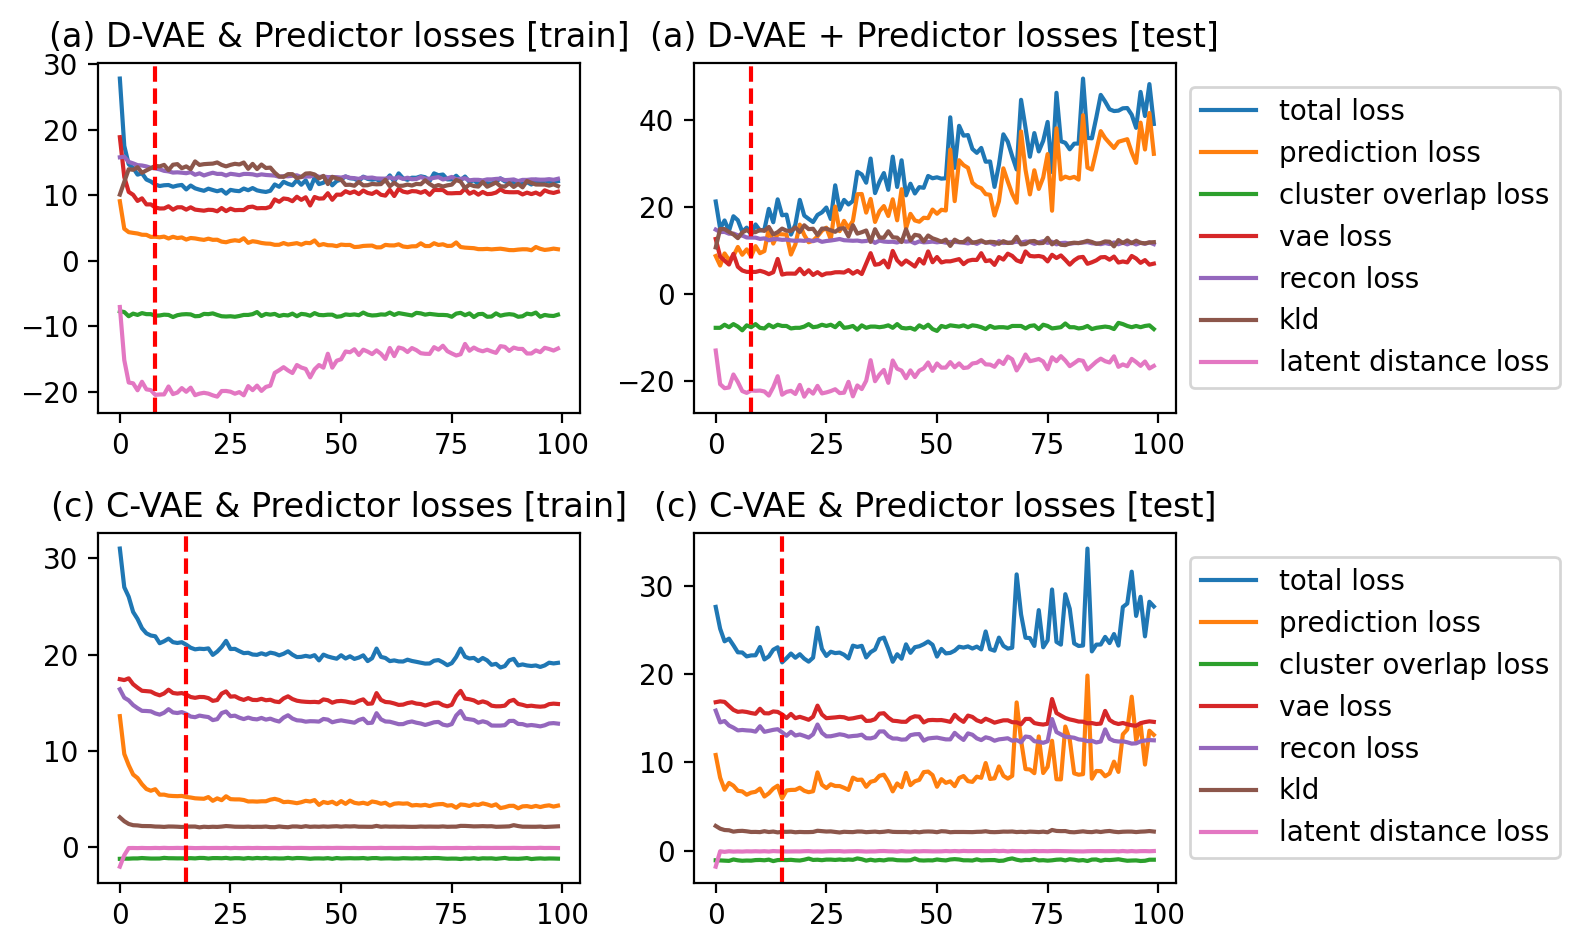

k = 1:
round 0:


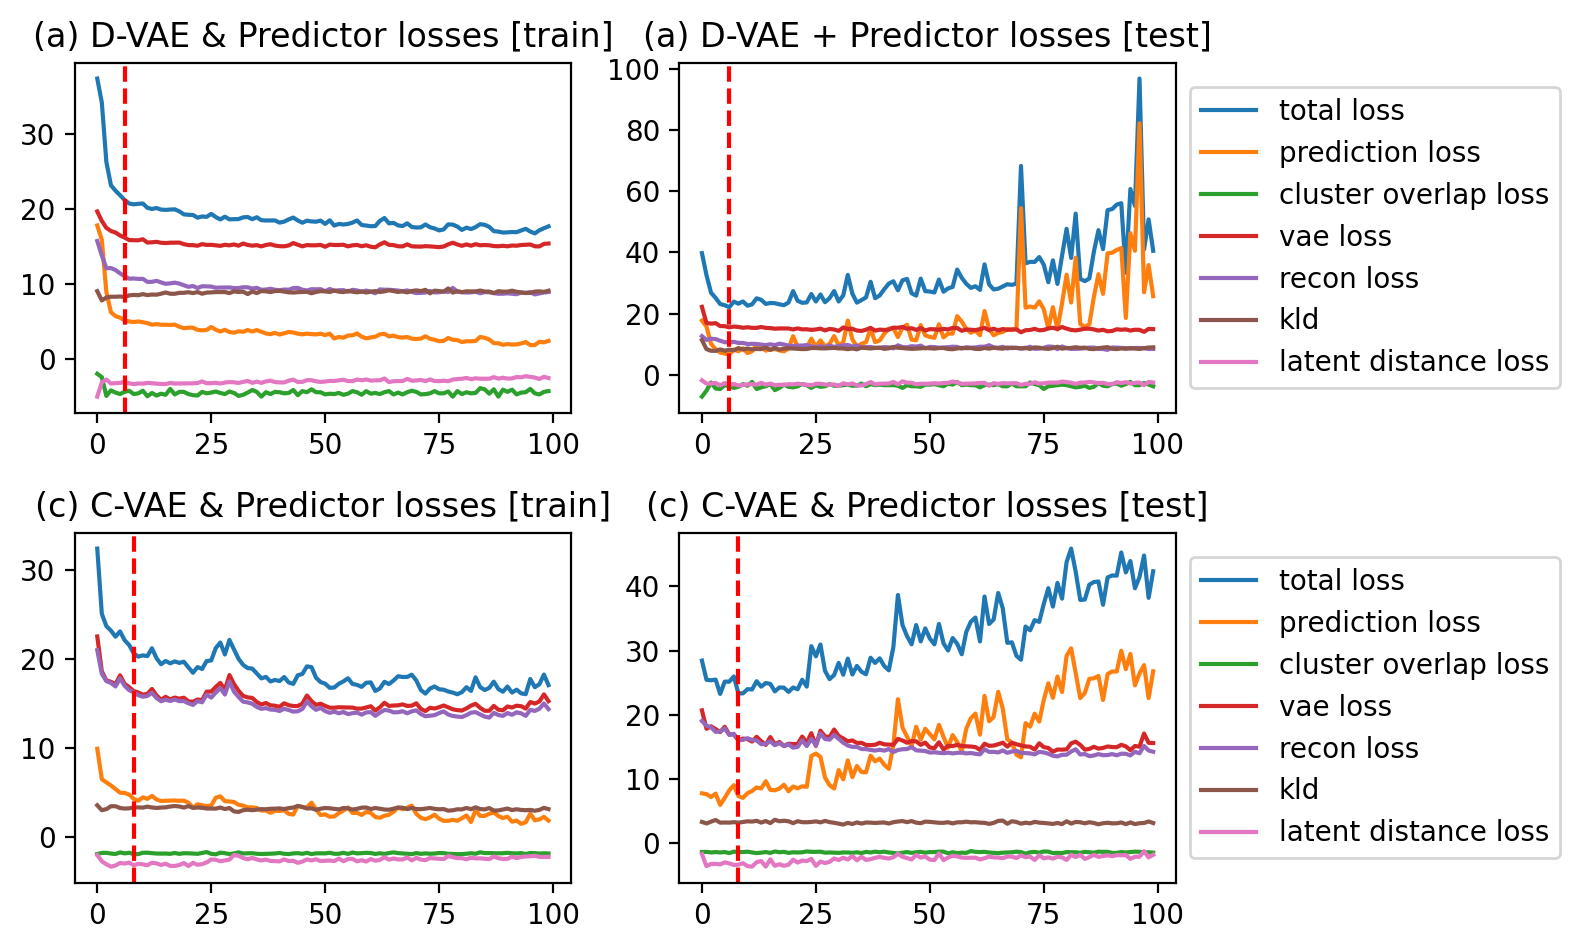

round 1:


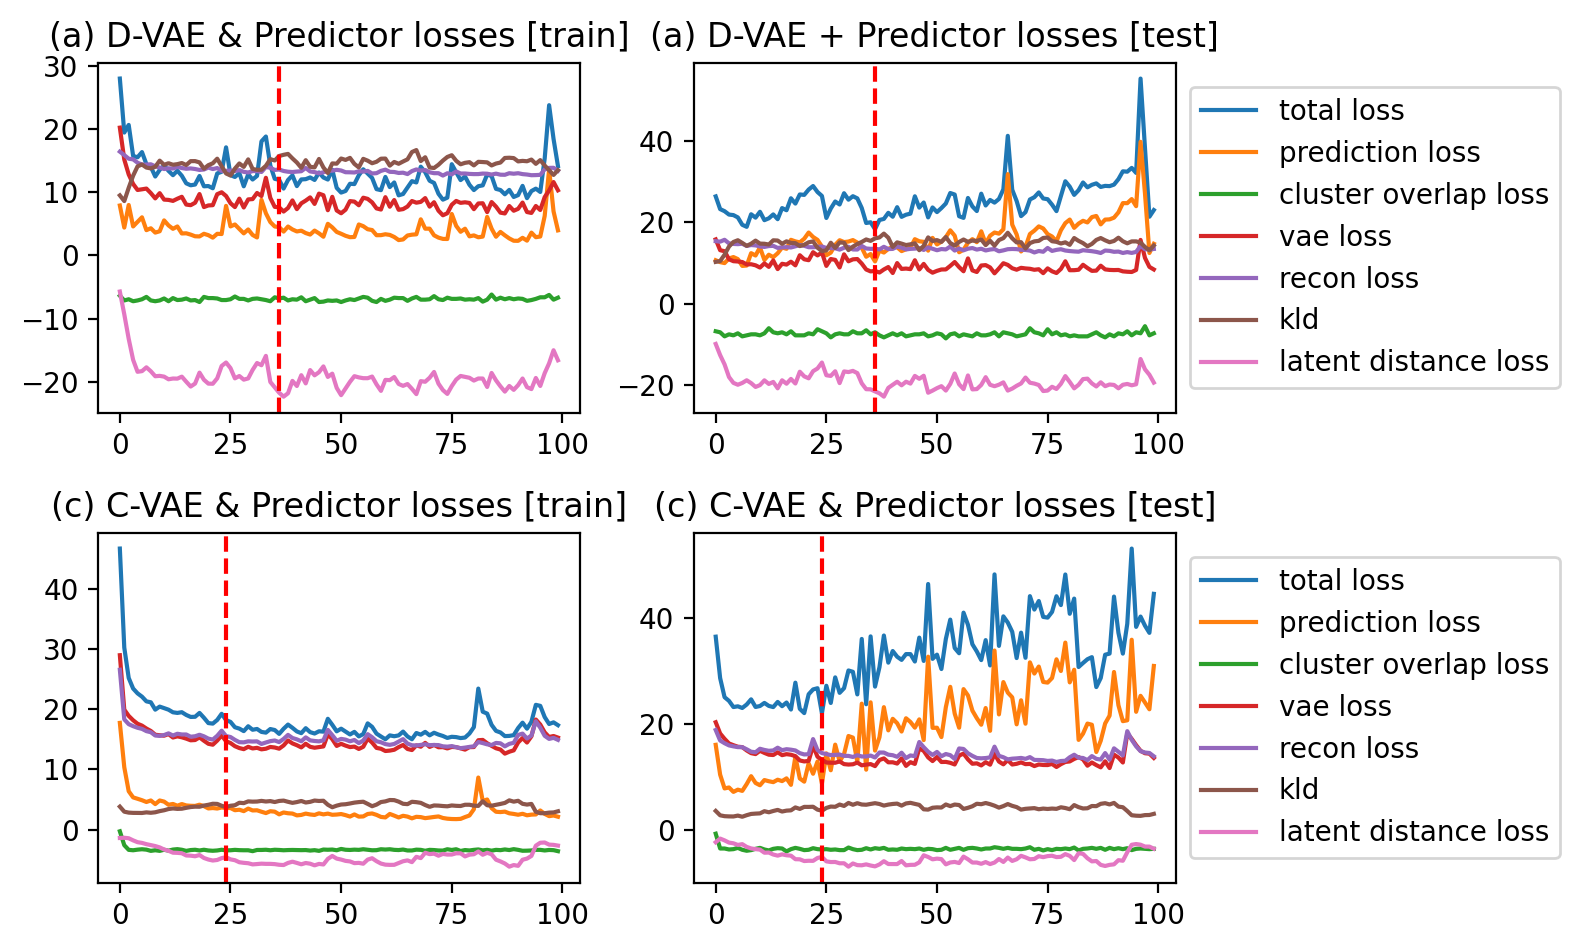

round 2:


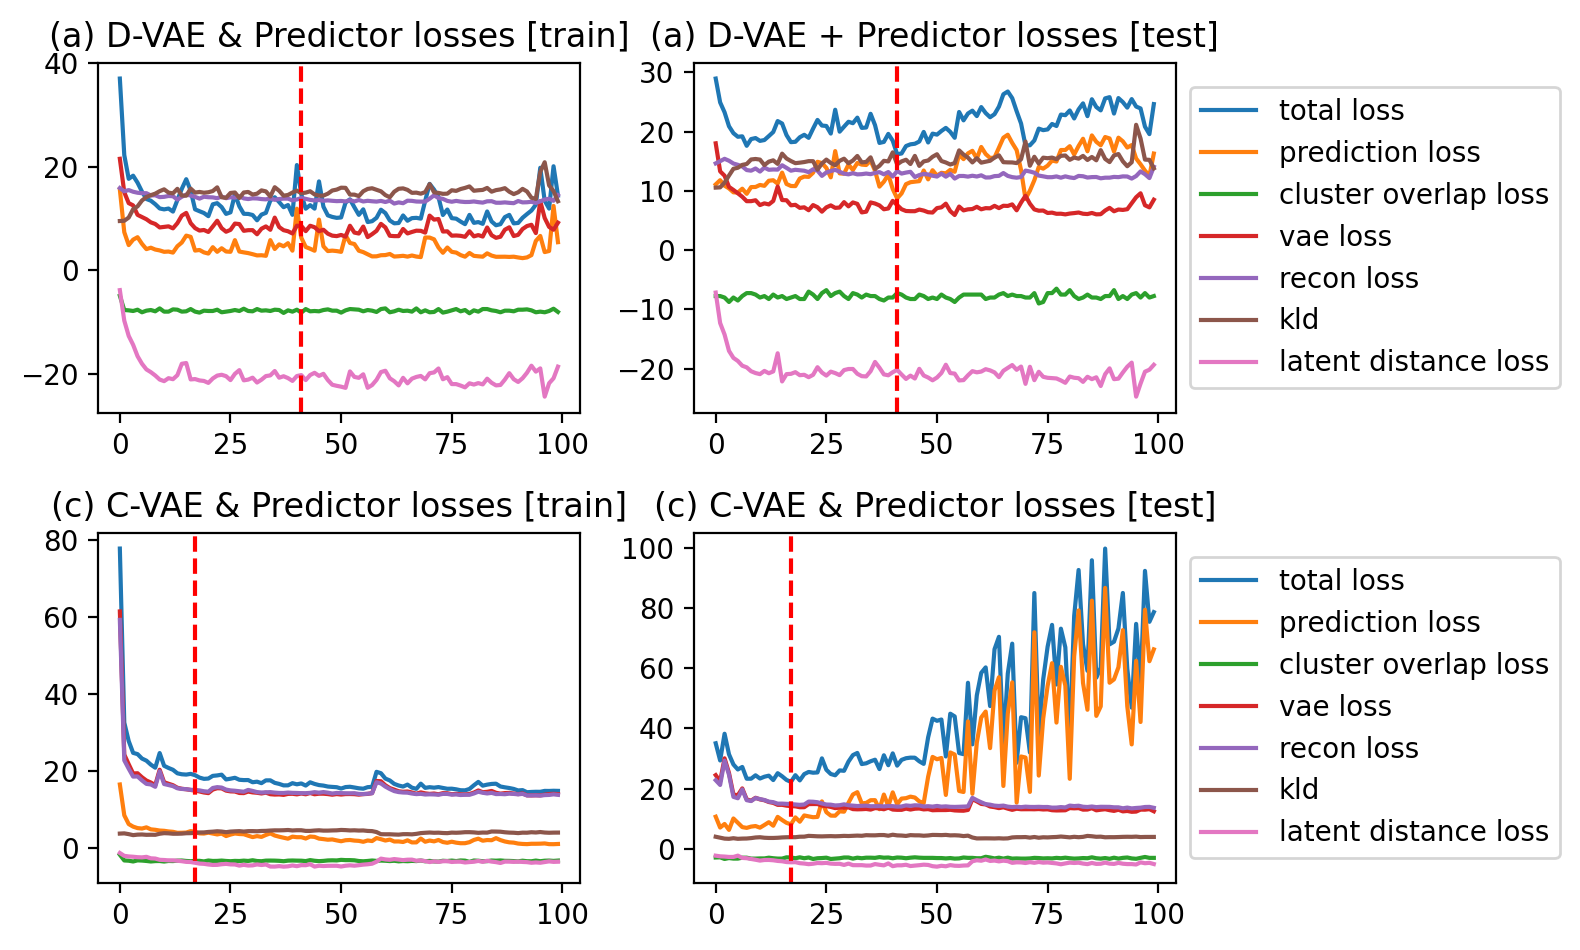

round 3:


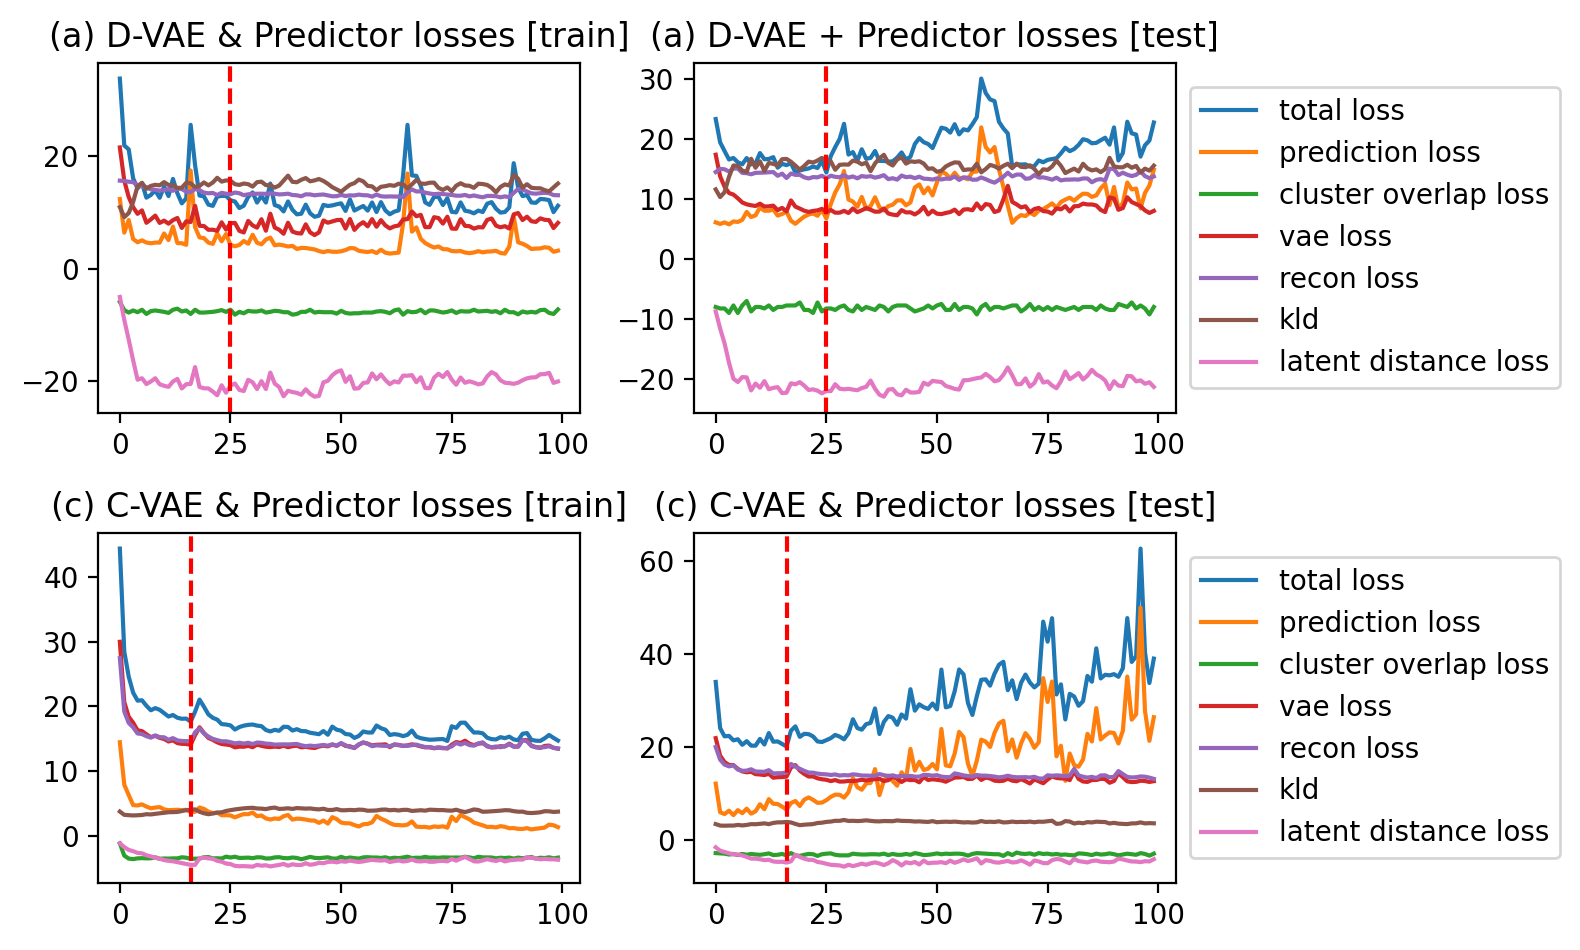

round 4:


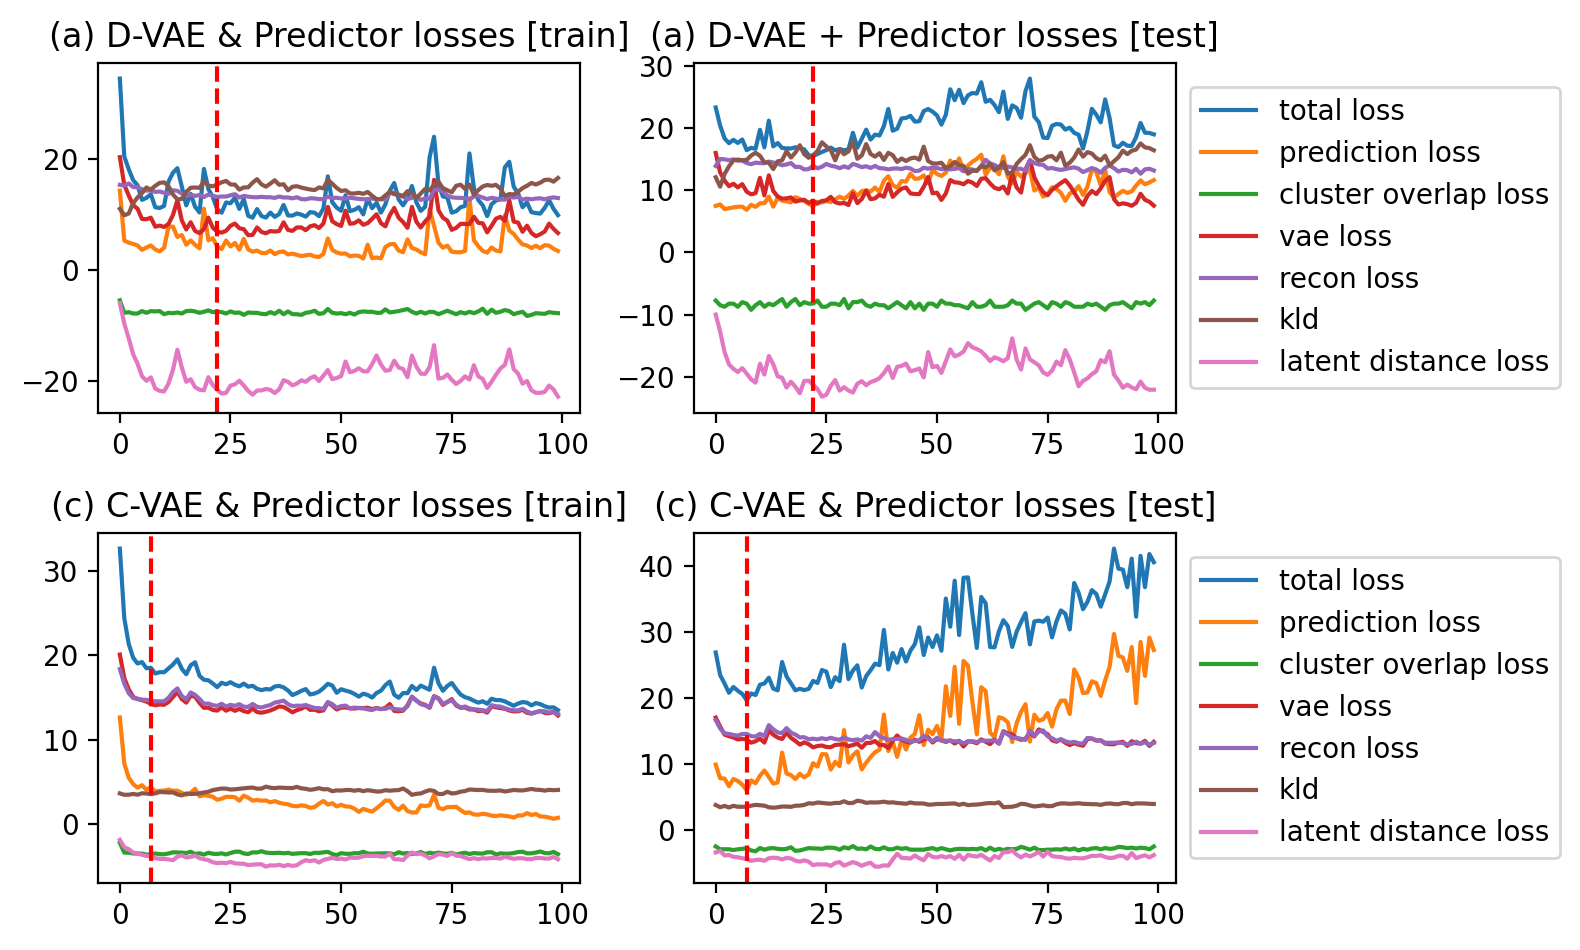

In [32]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[b][k], best_epoch_1round = best_epos_list[b][k],
                                              plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_losses_b{b}_k{k}.png')
        

k = 0:
round 0:


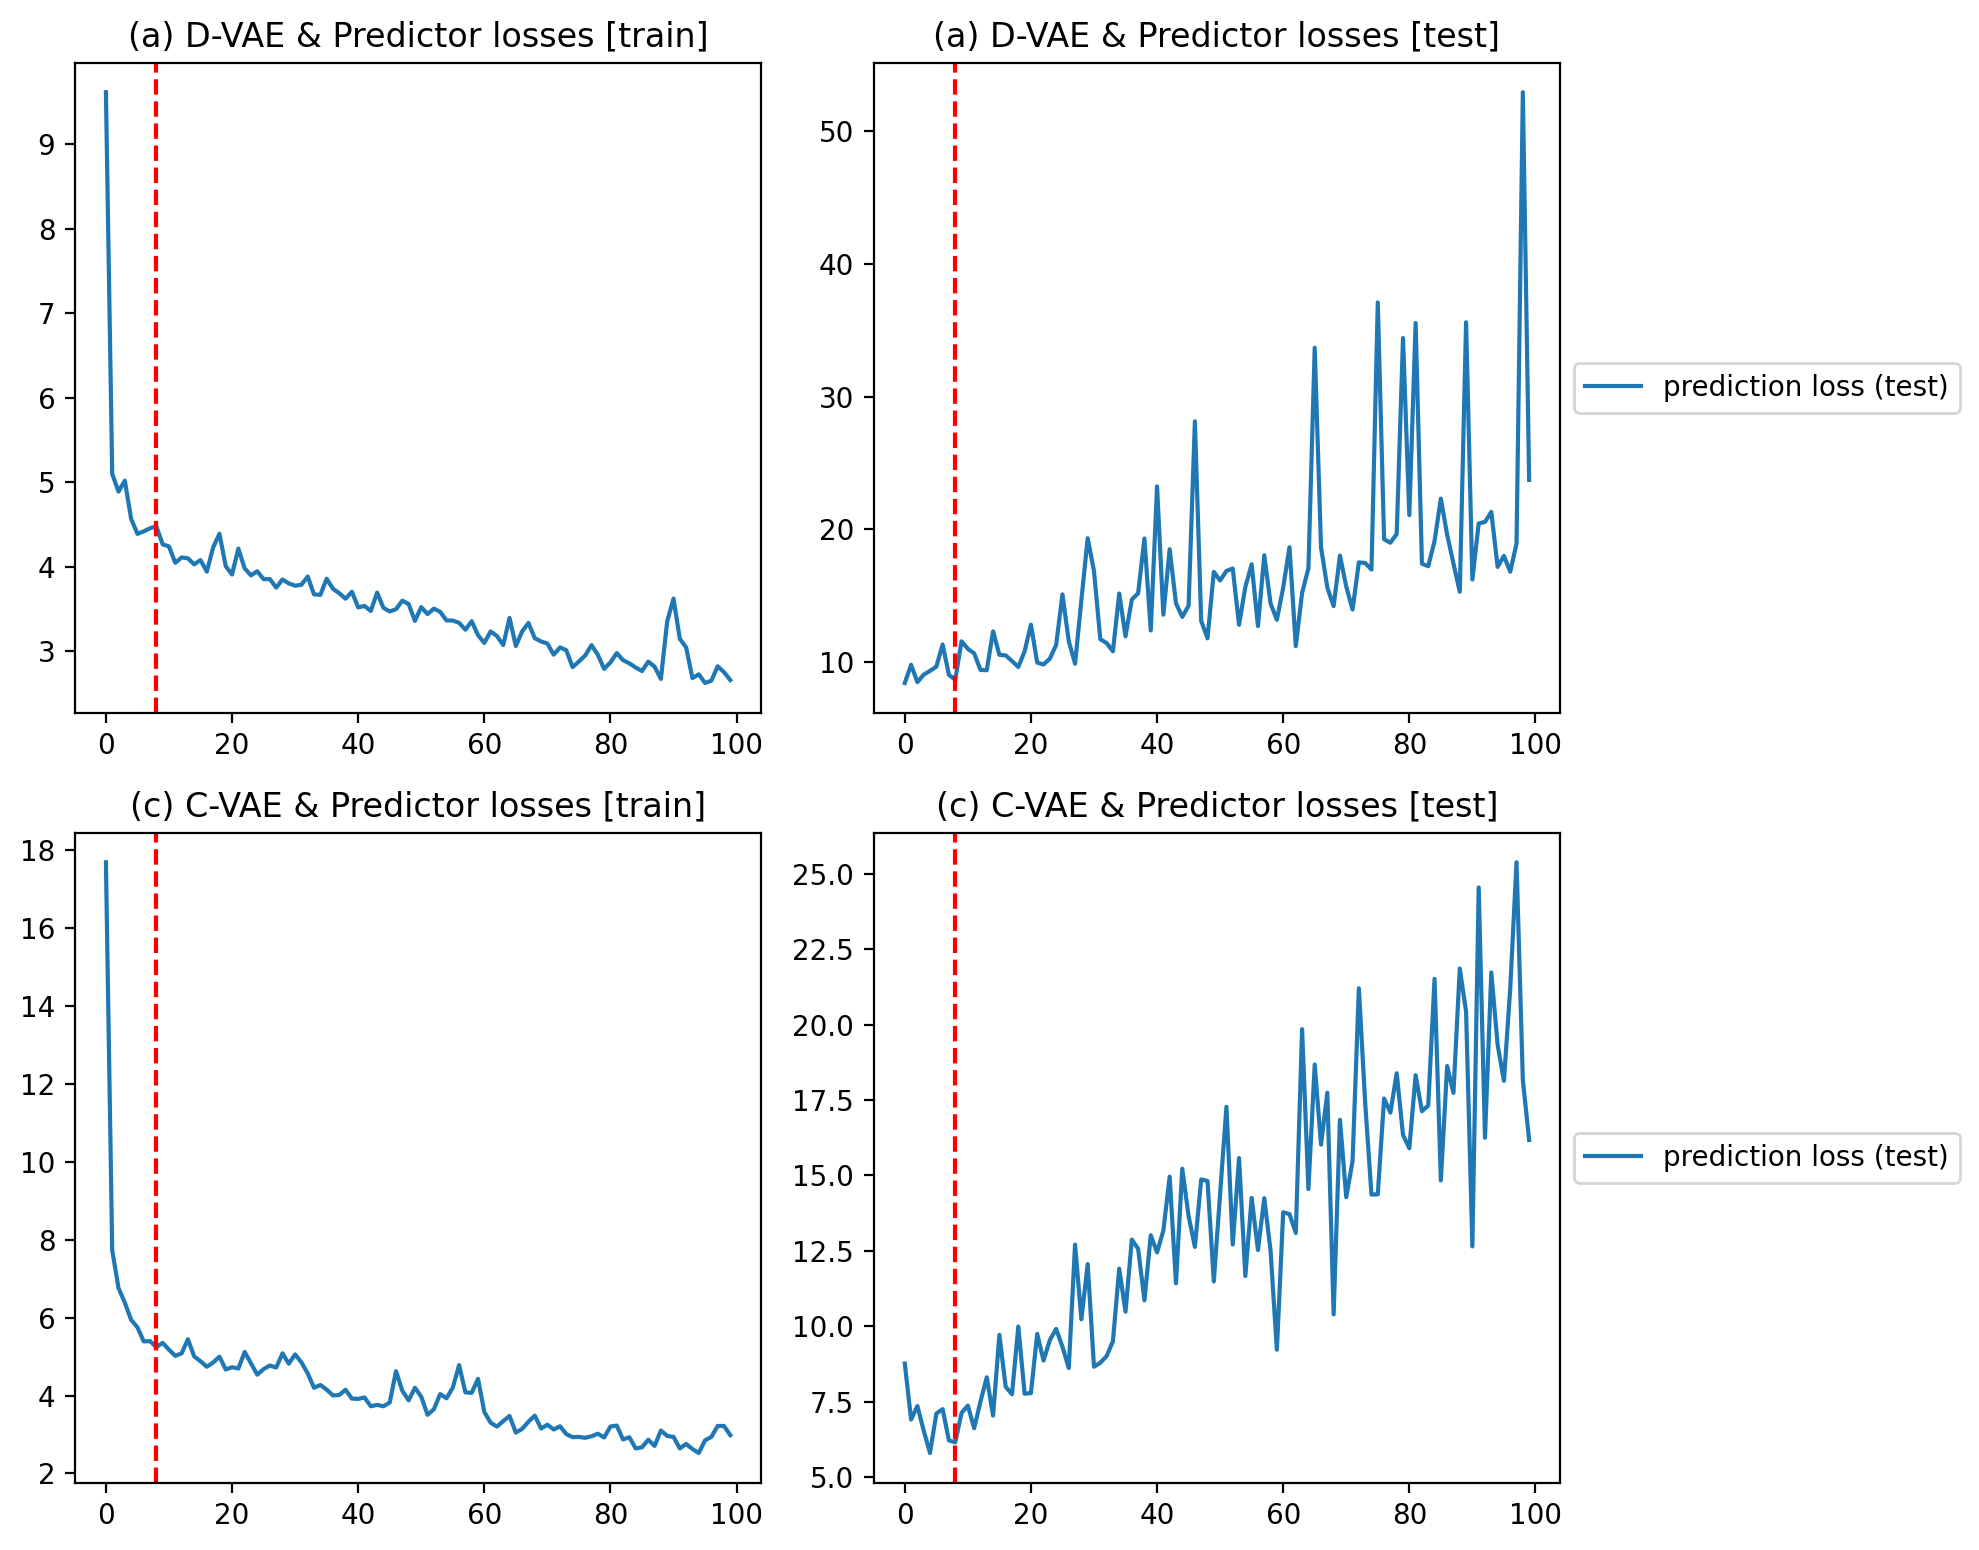

round 1:


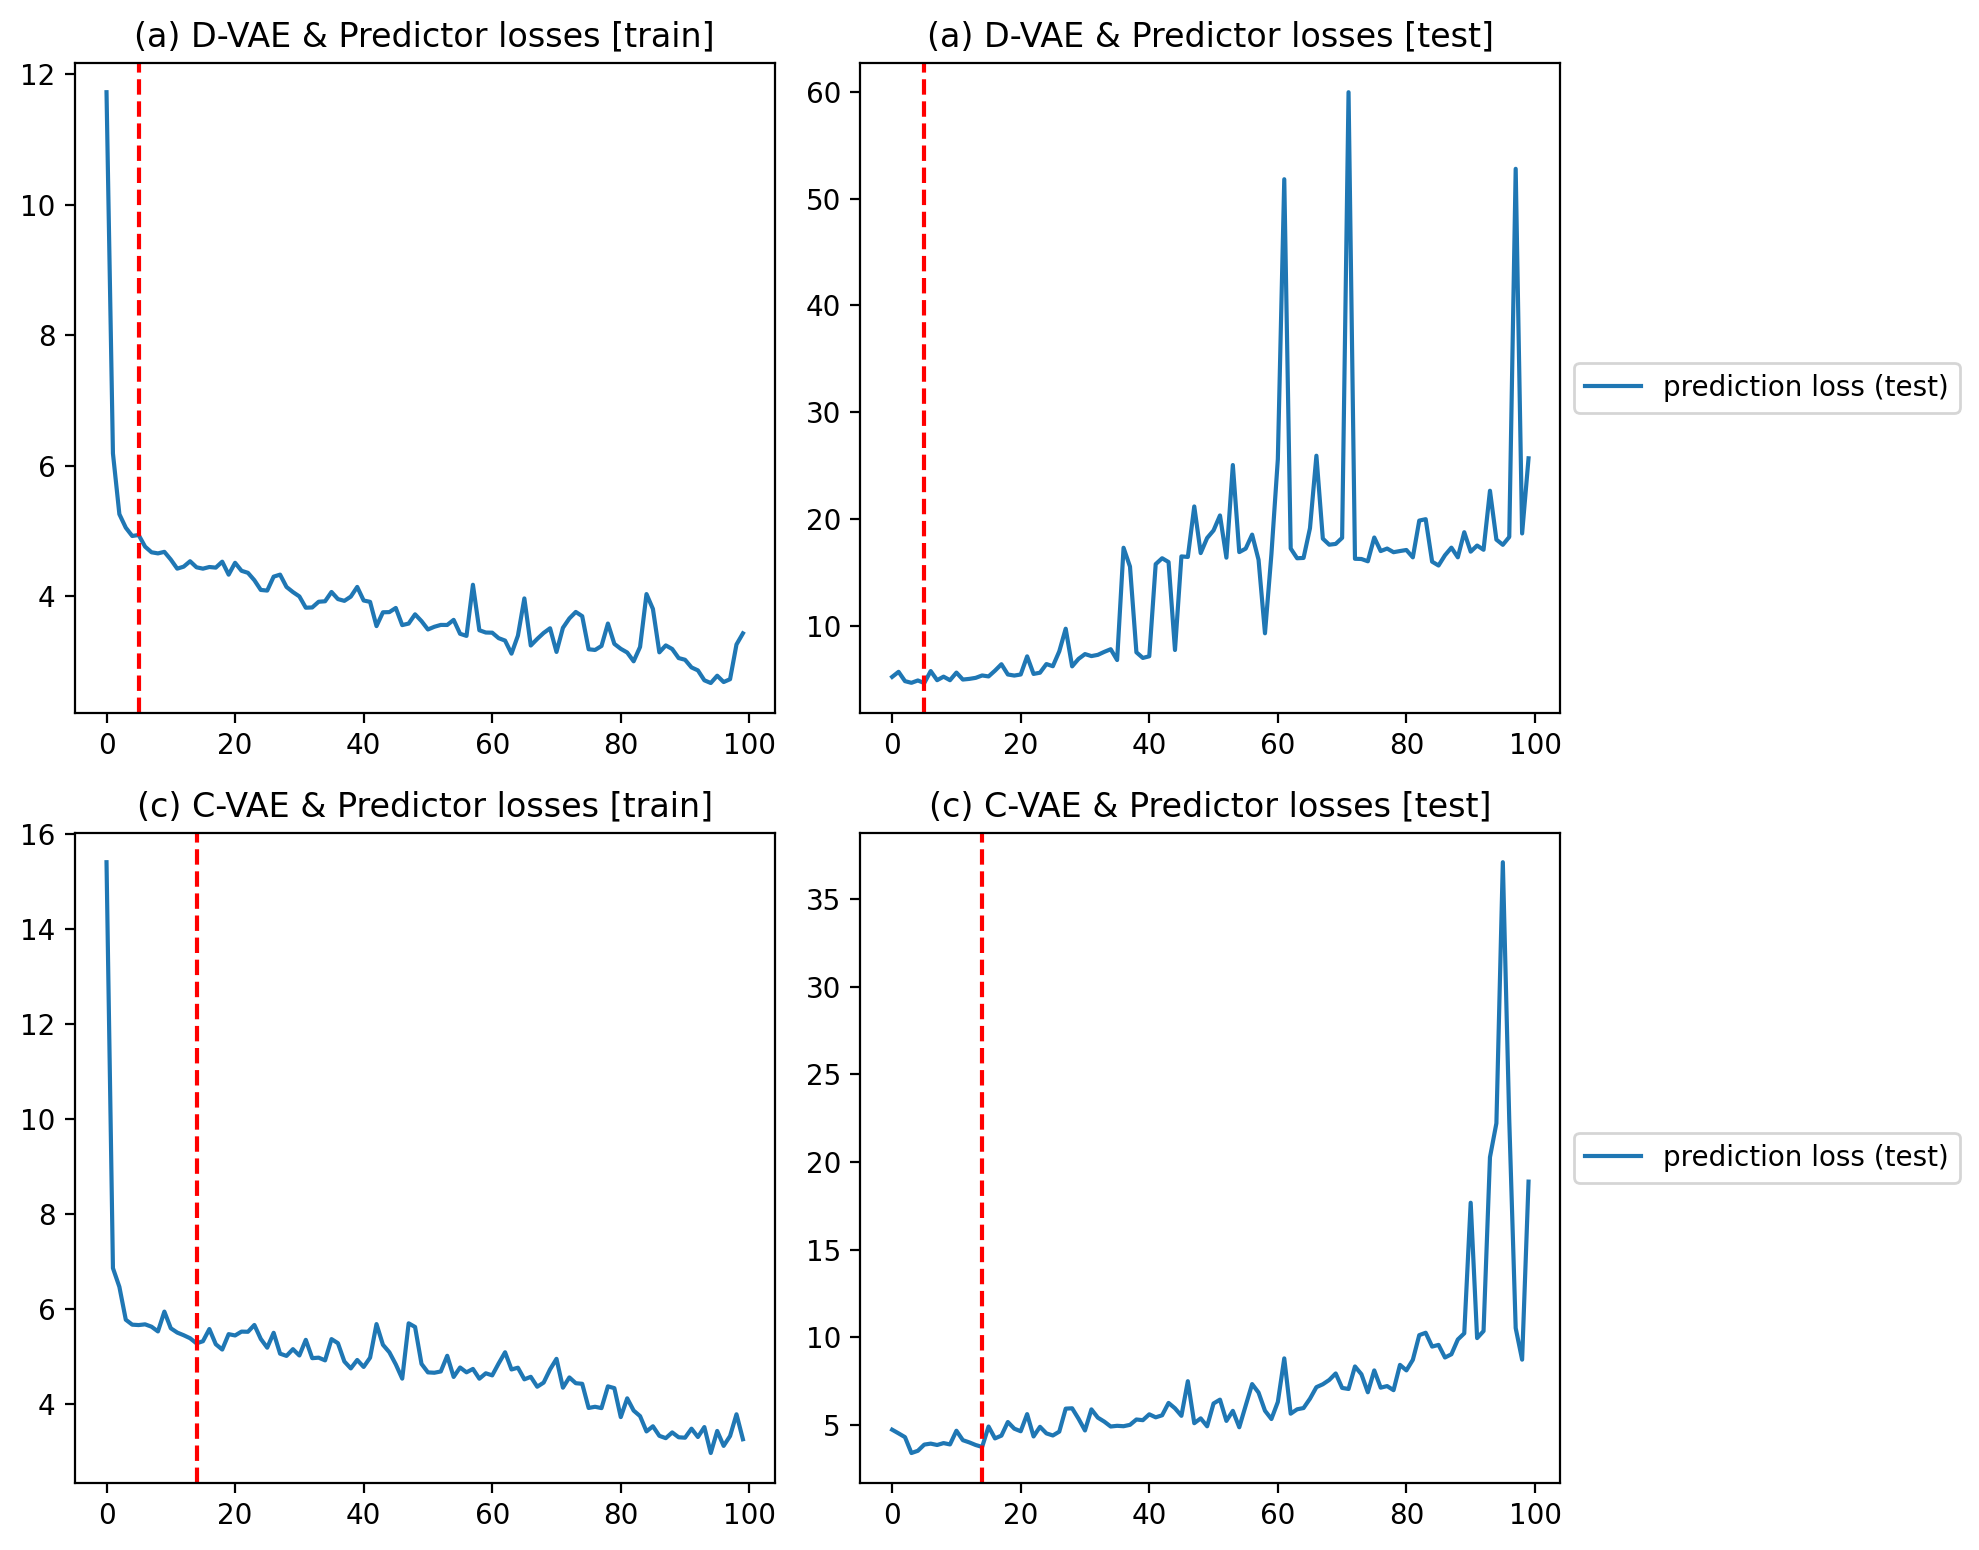

round 2:


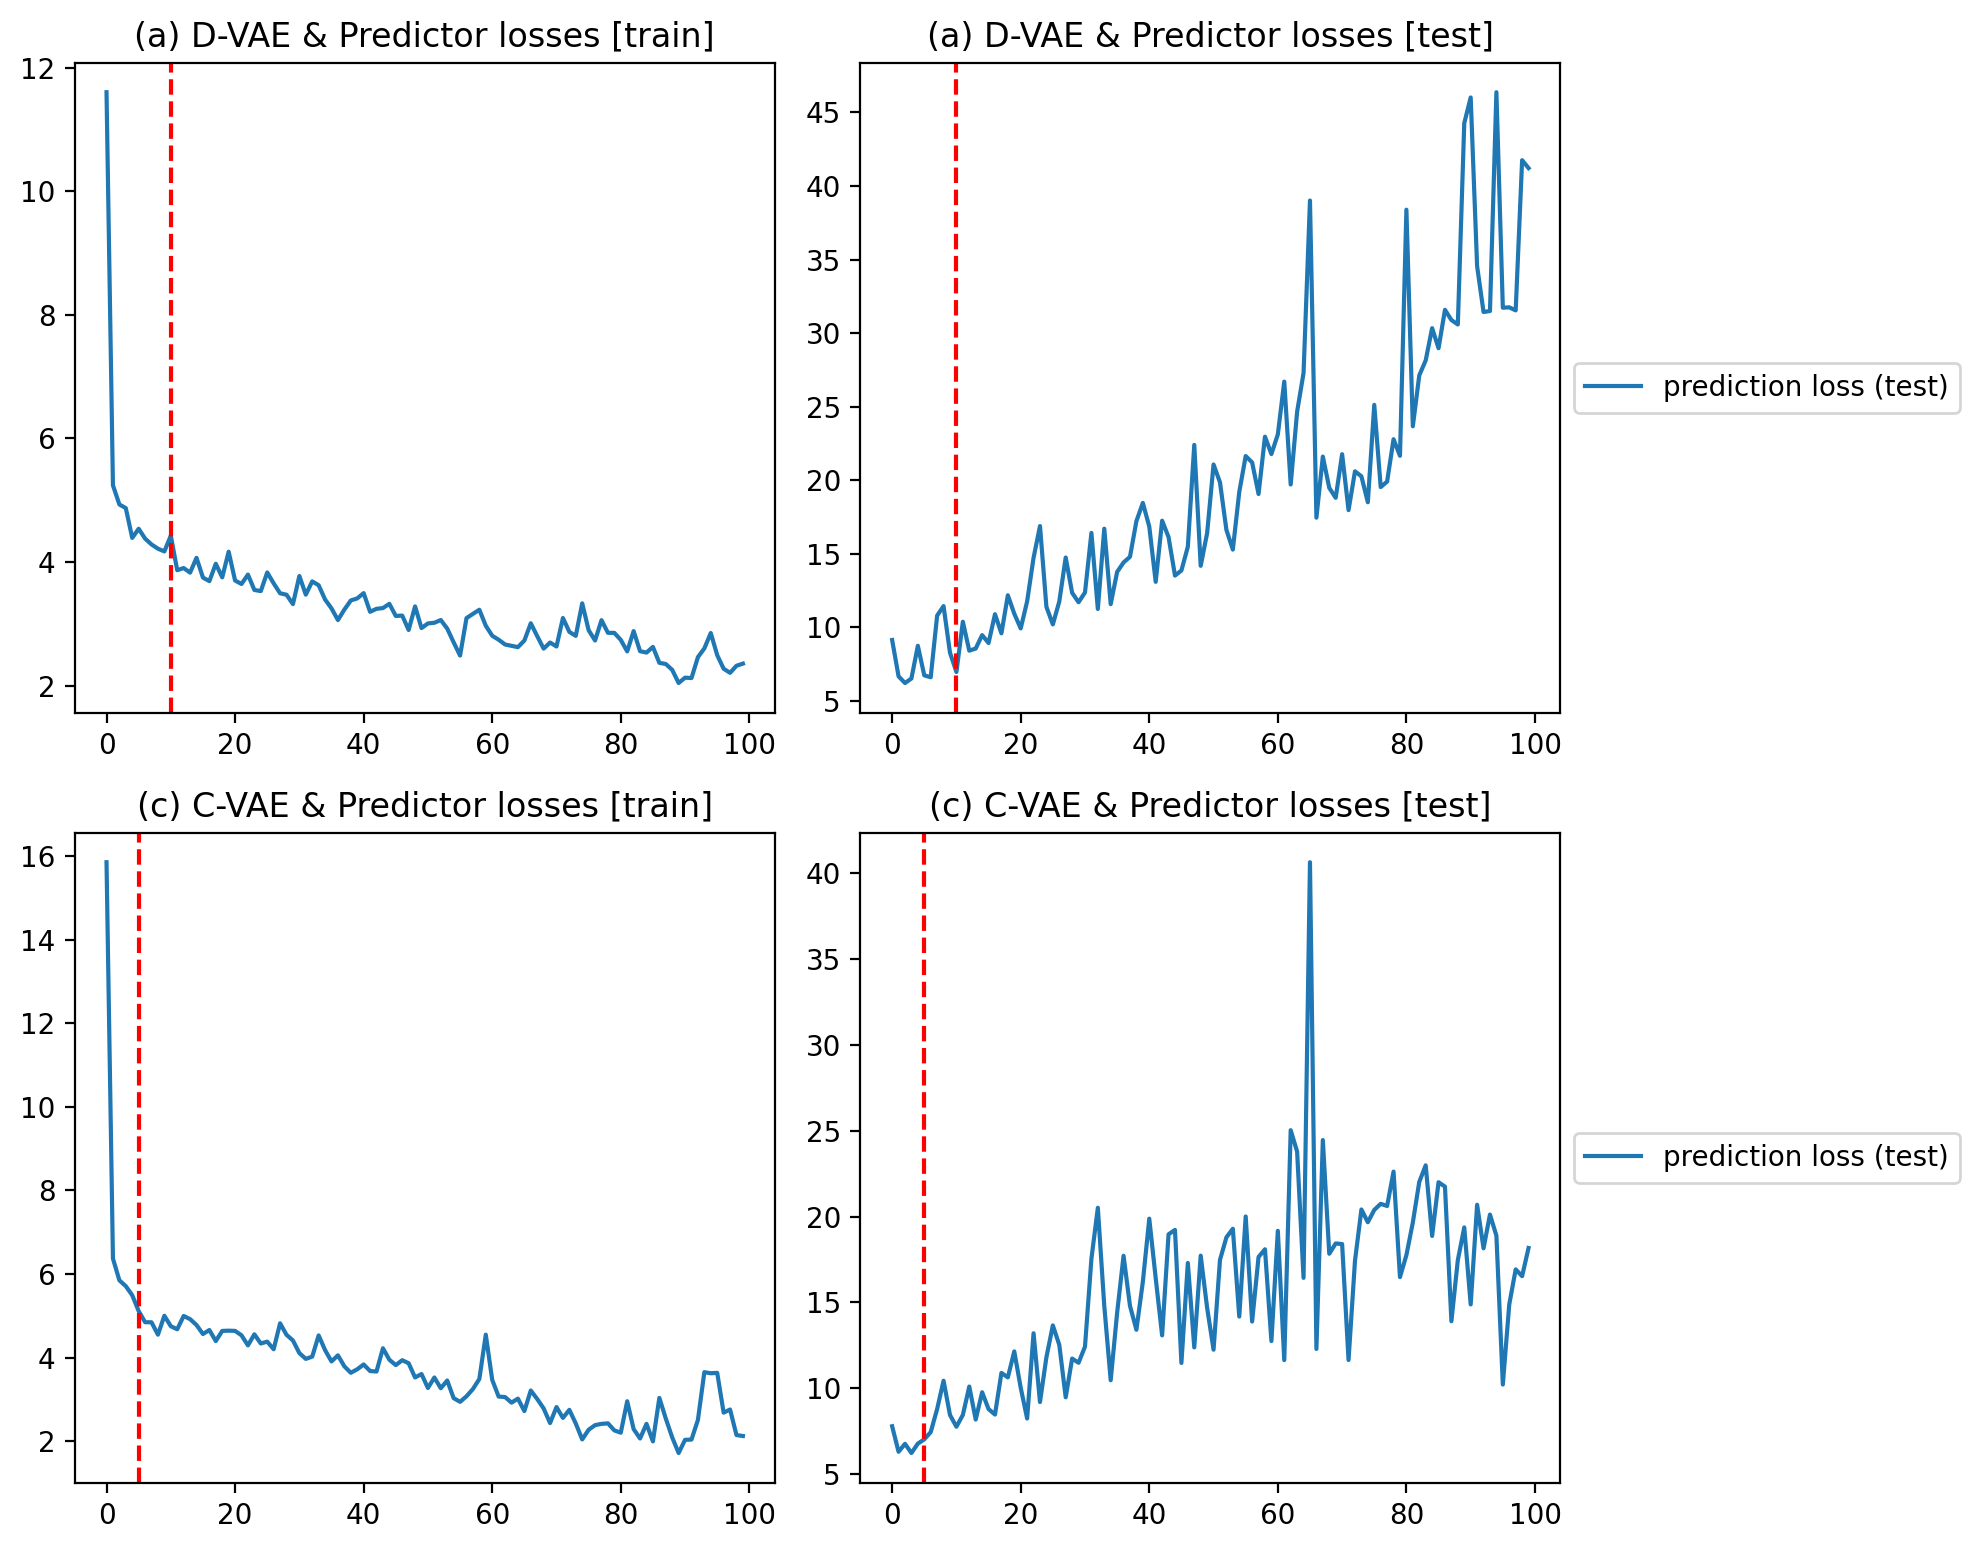

round 3:


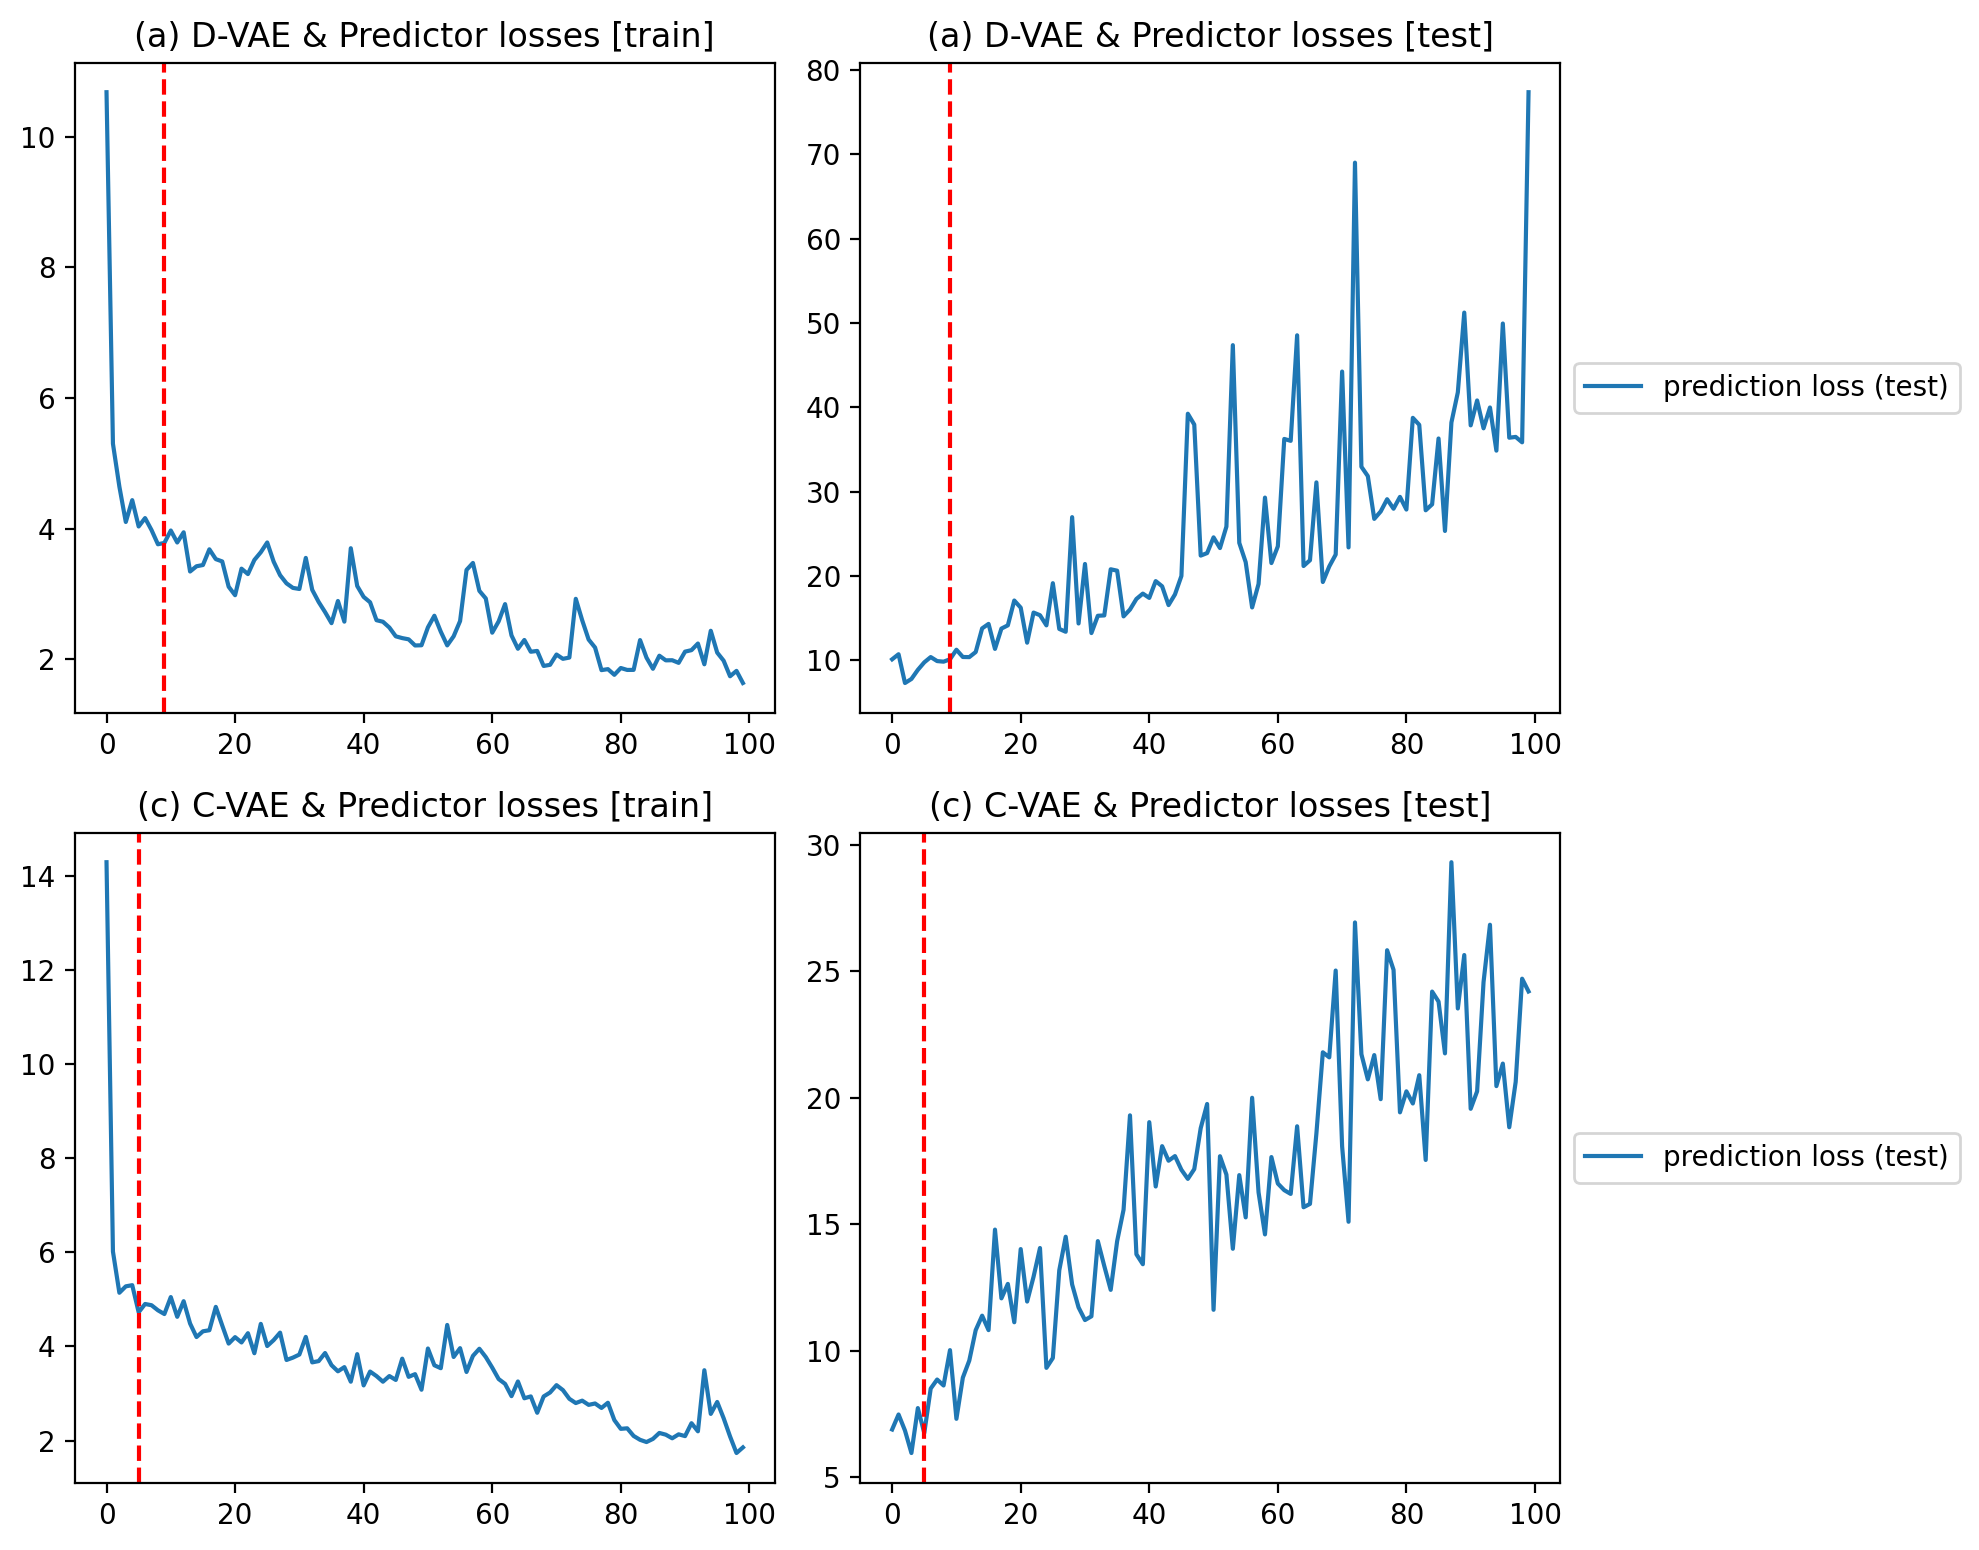

round 4:


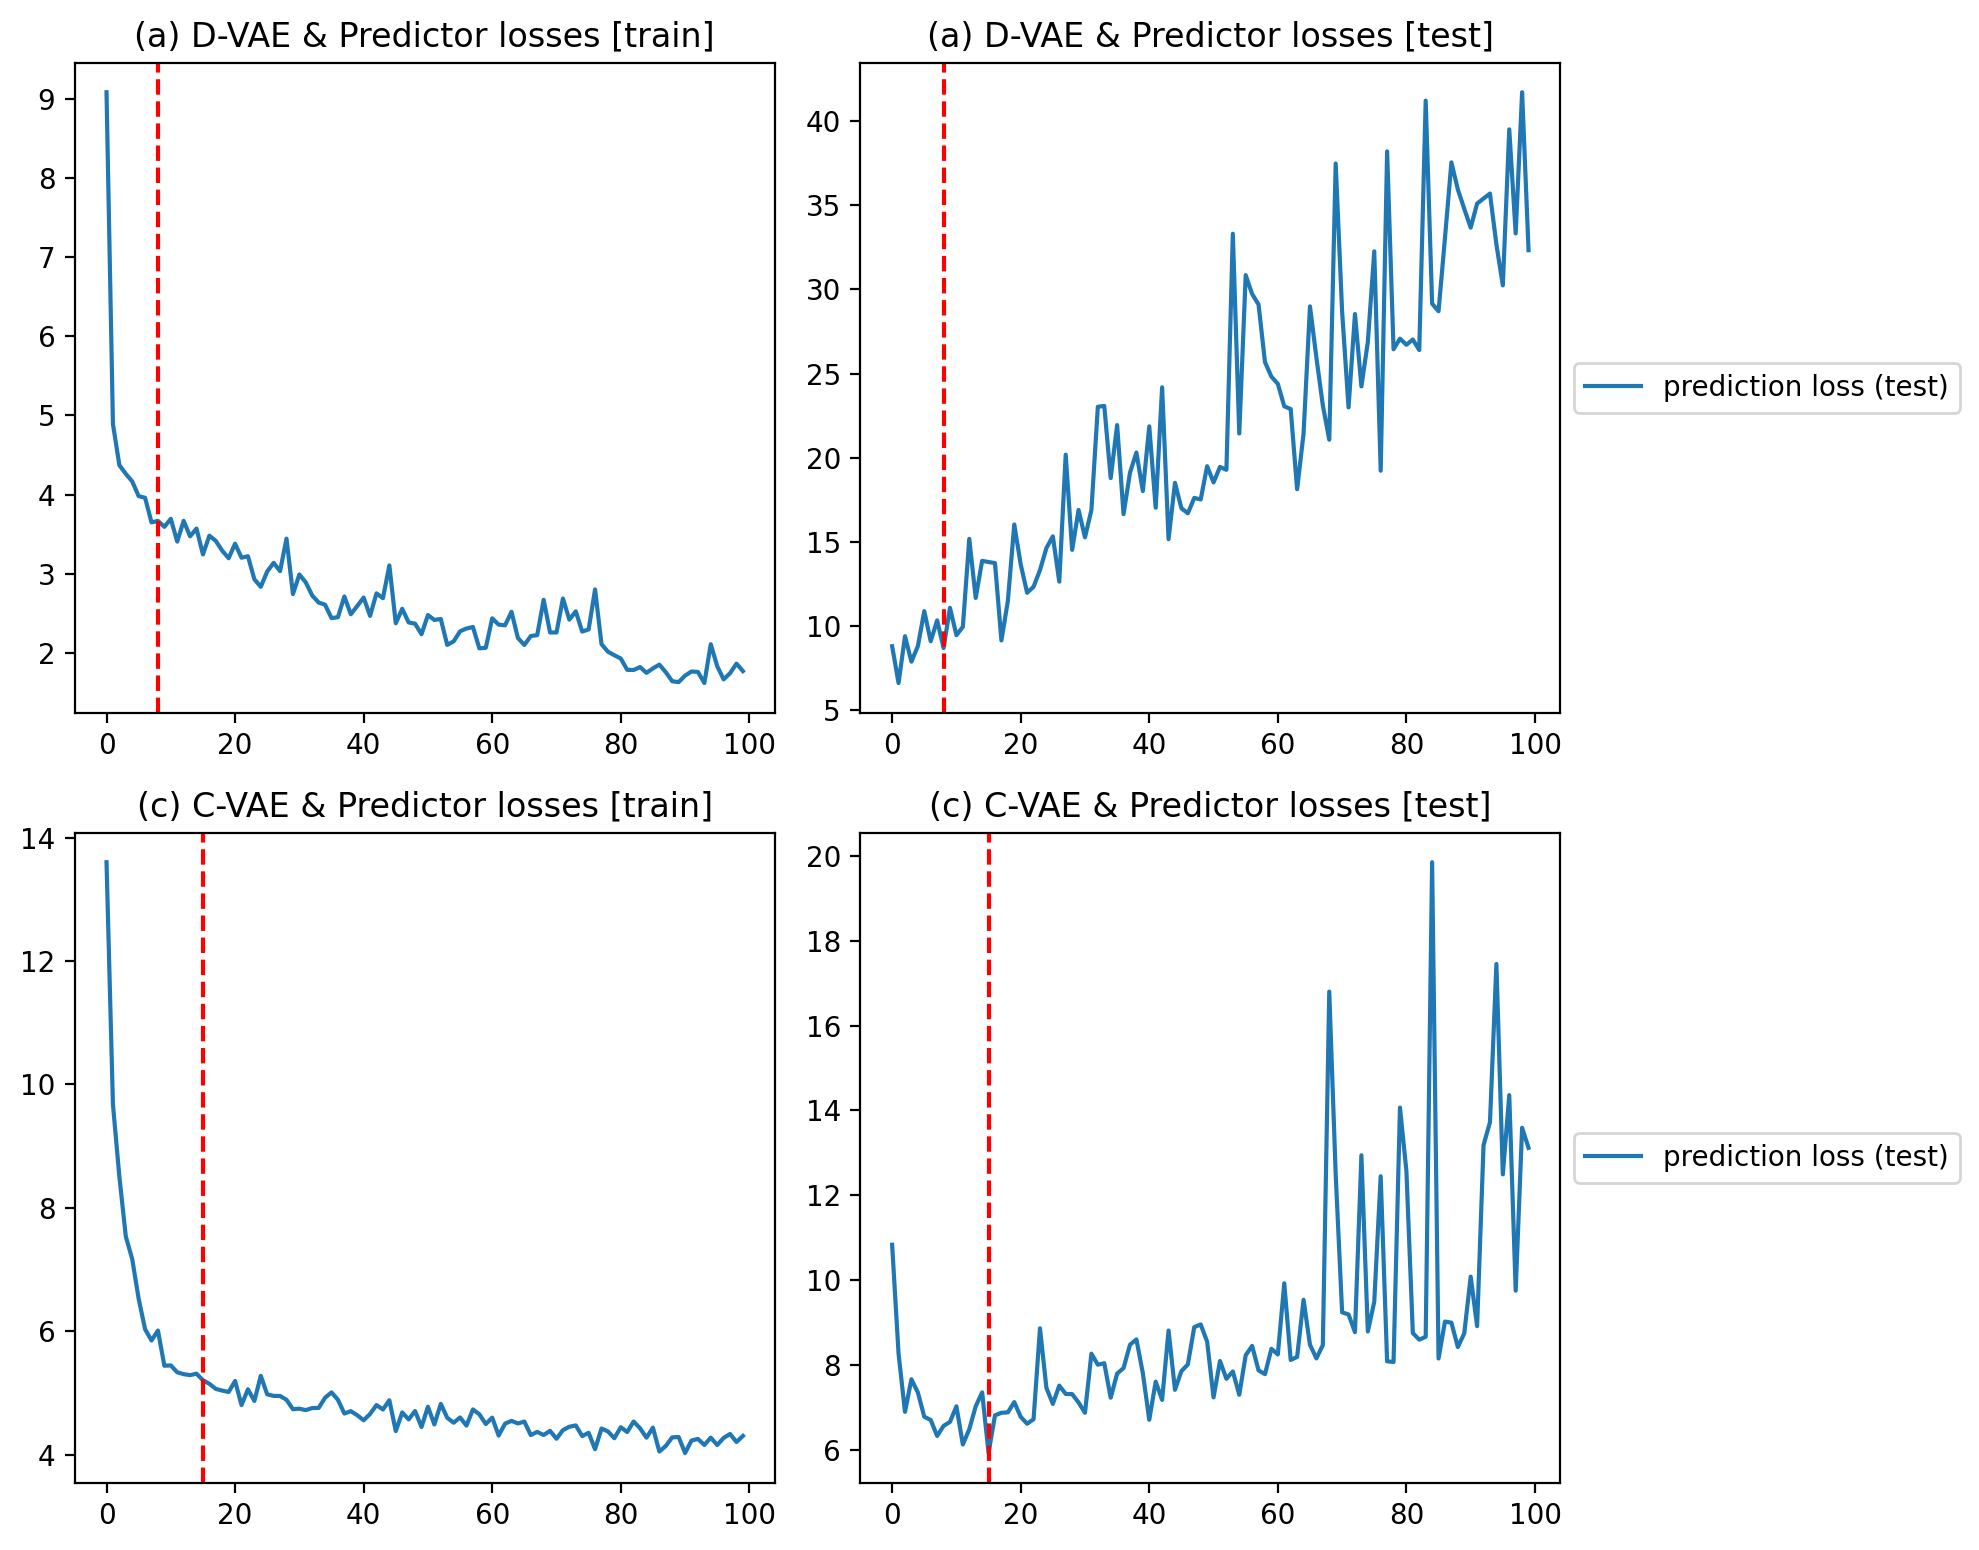

k = 1:
round 0:


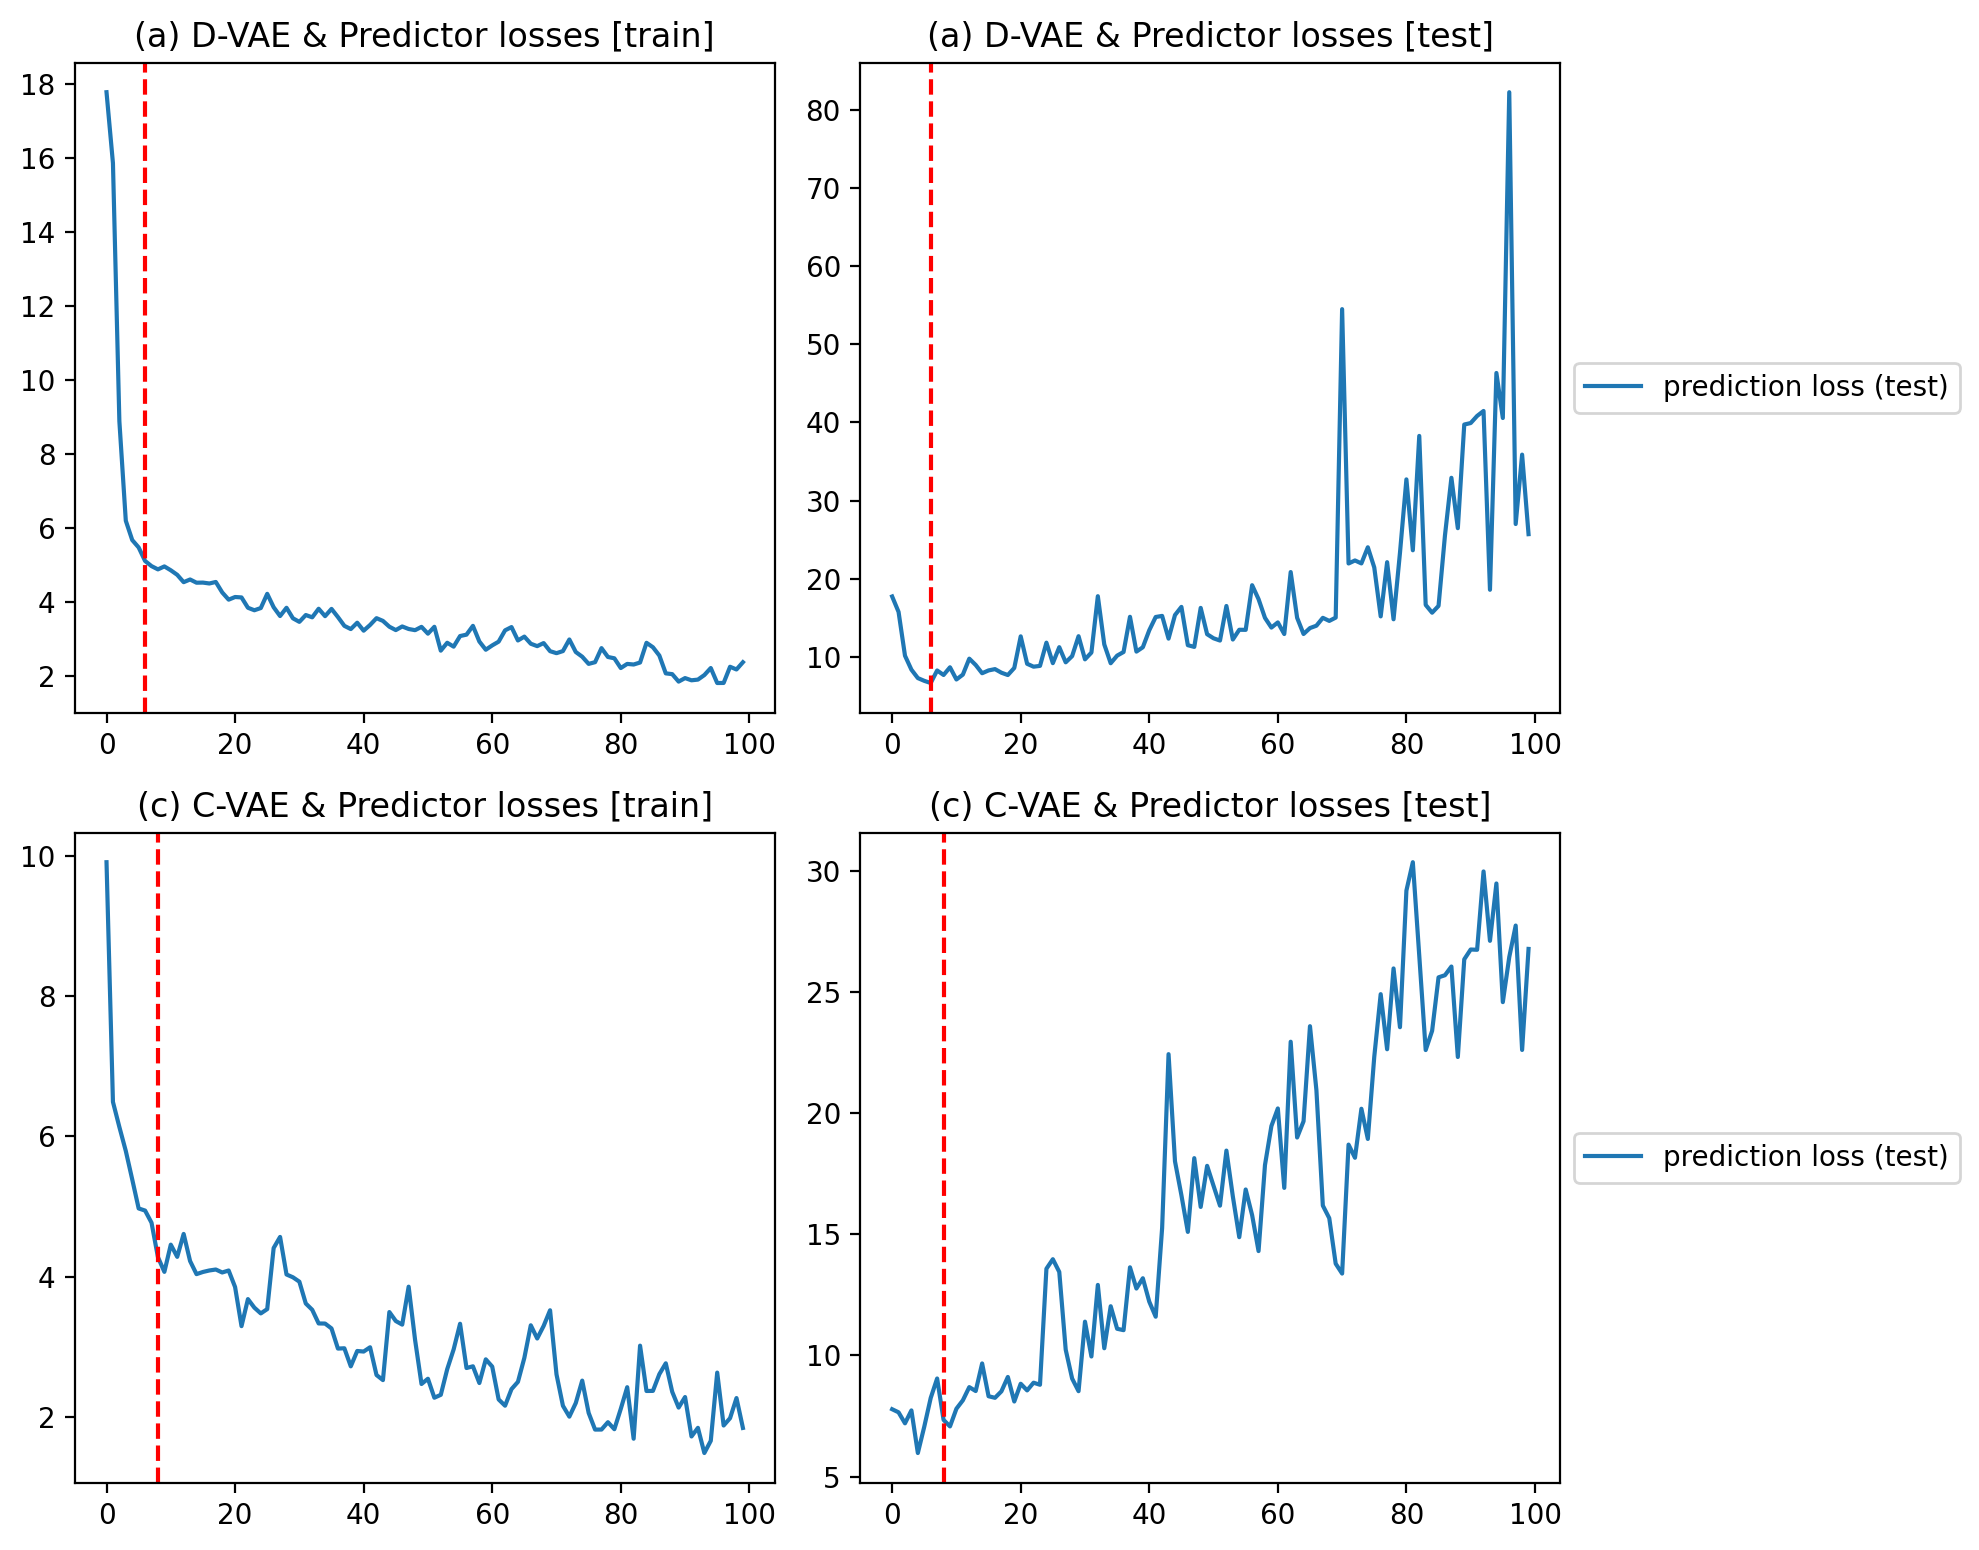

round 1:


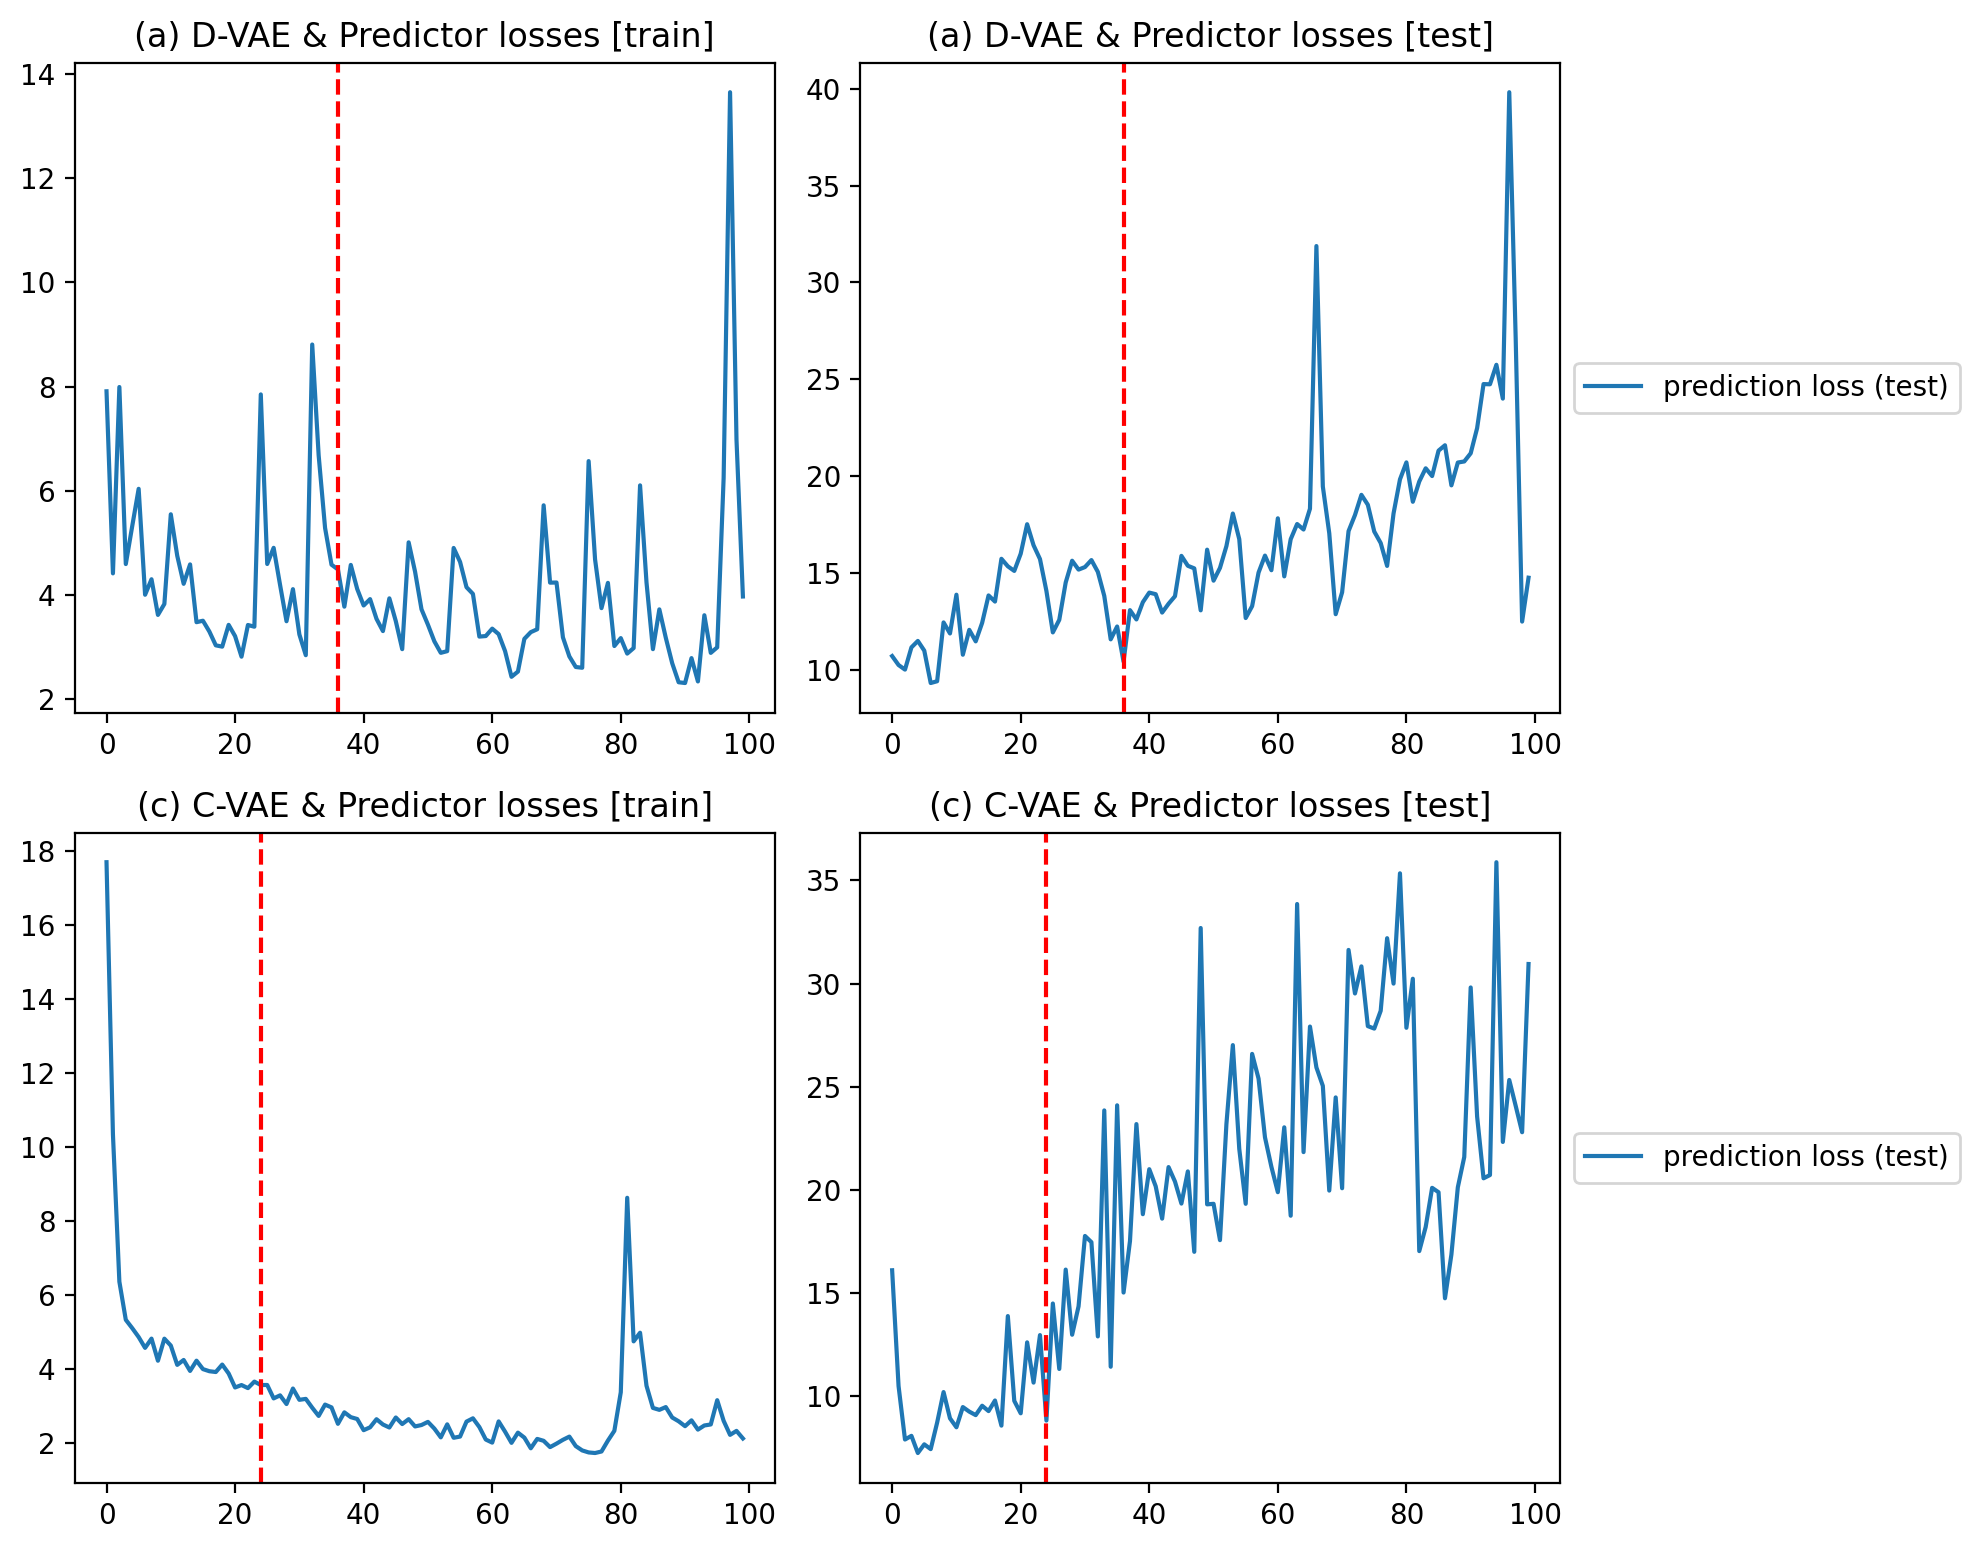

round 2:


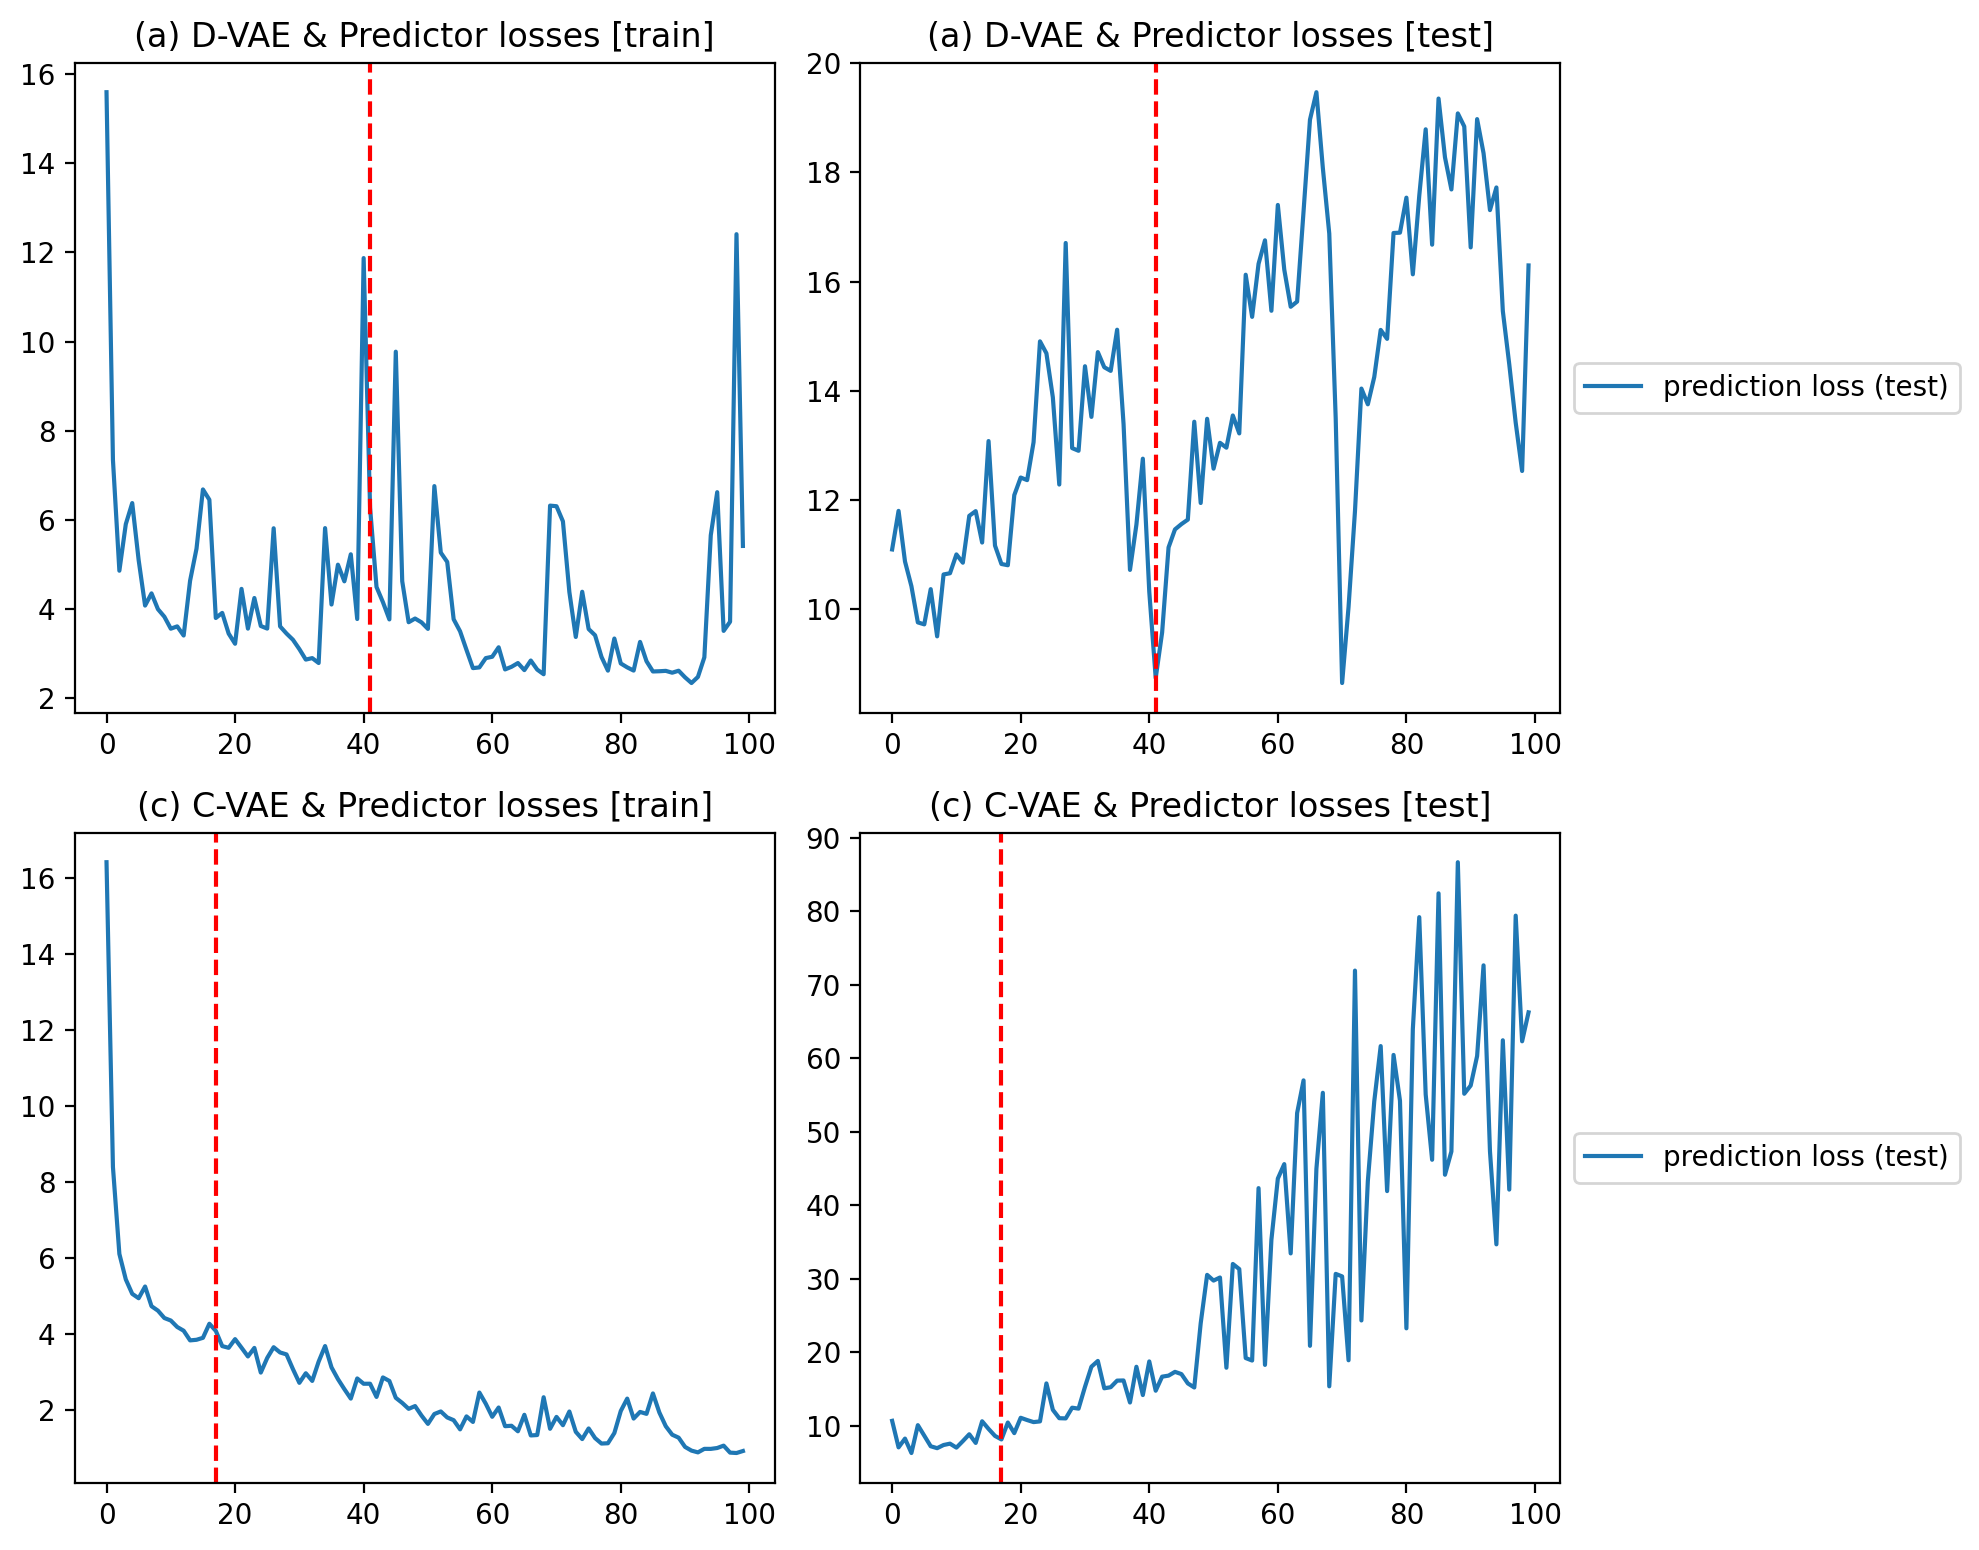

round 3:


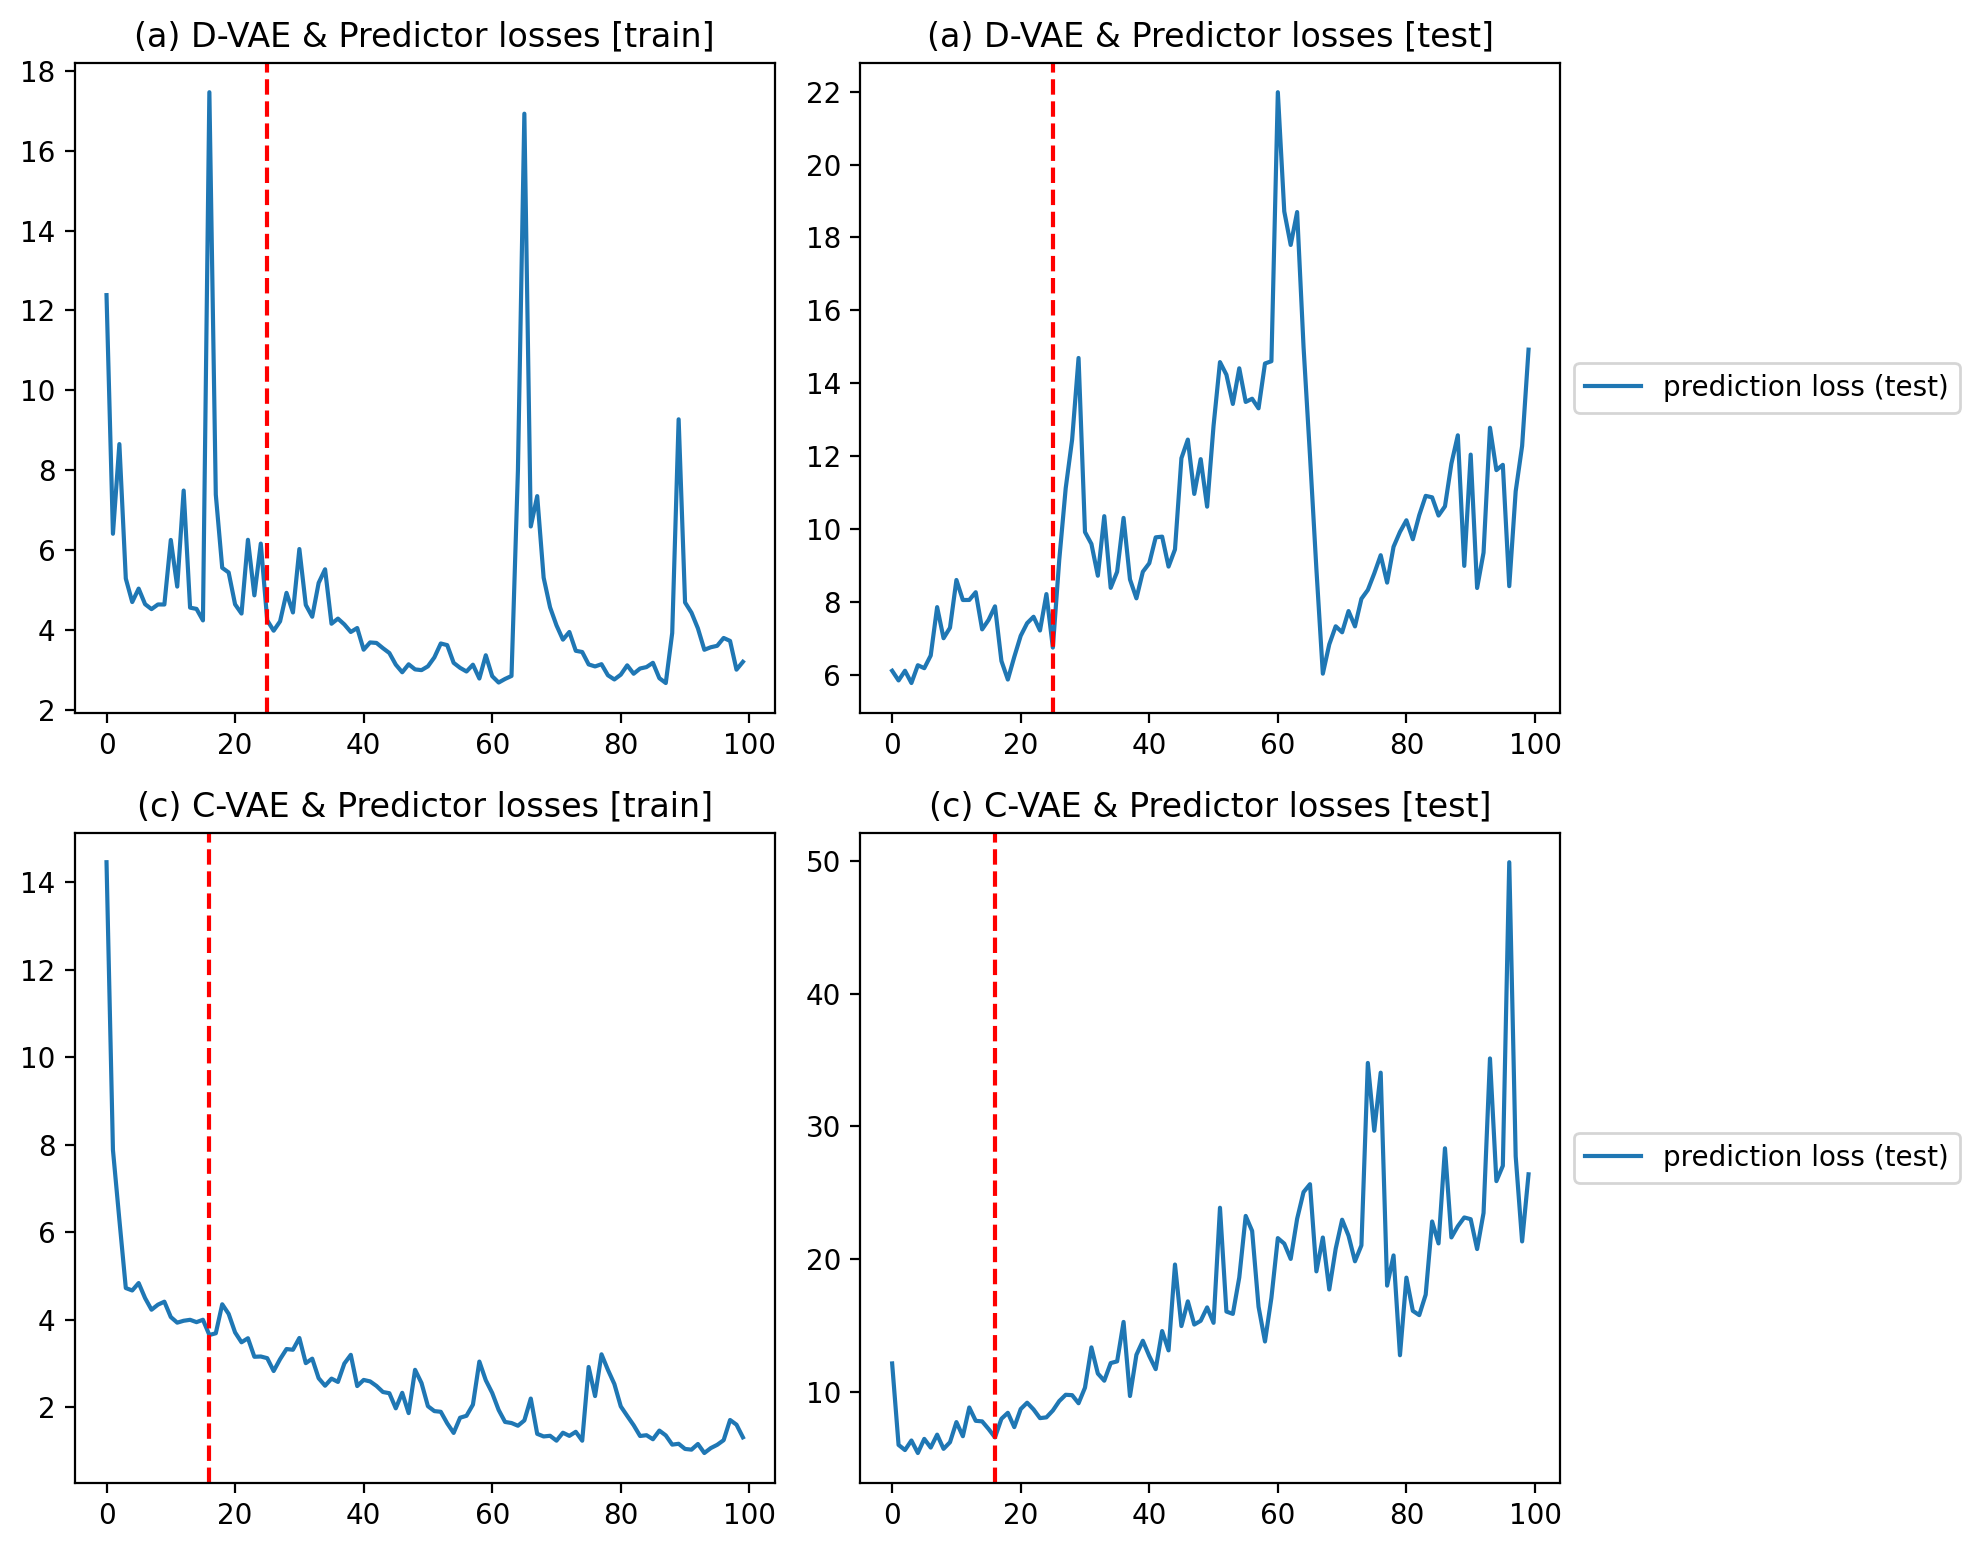

round 4:


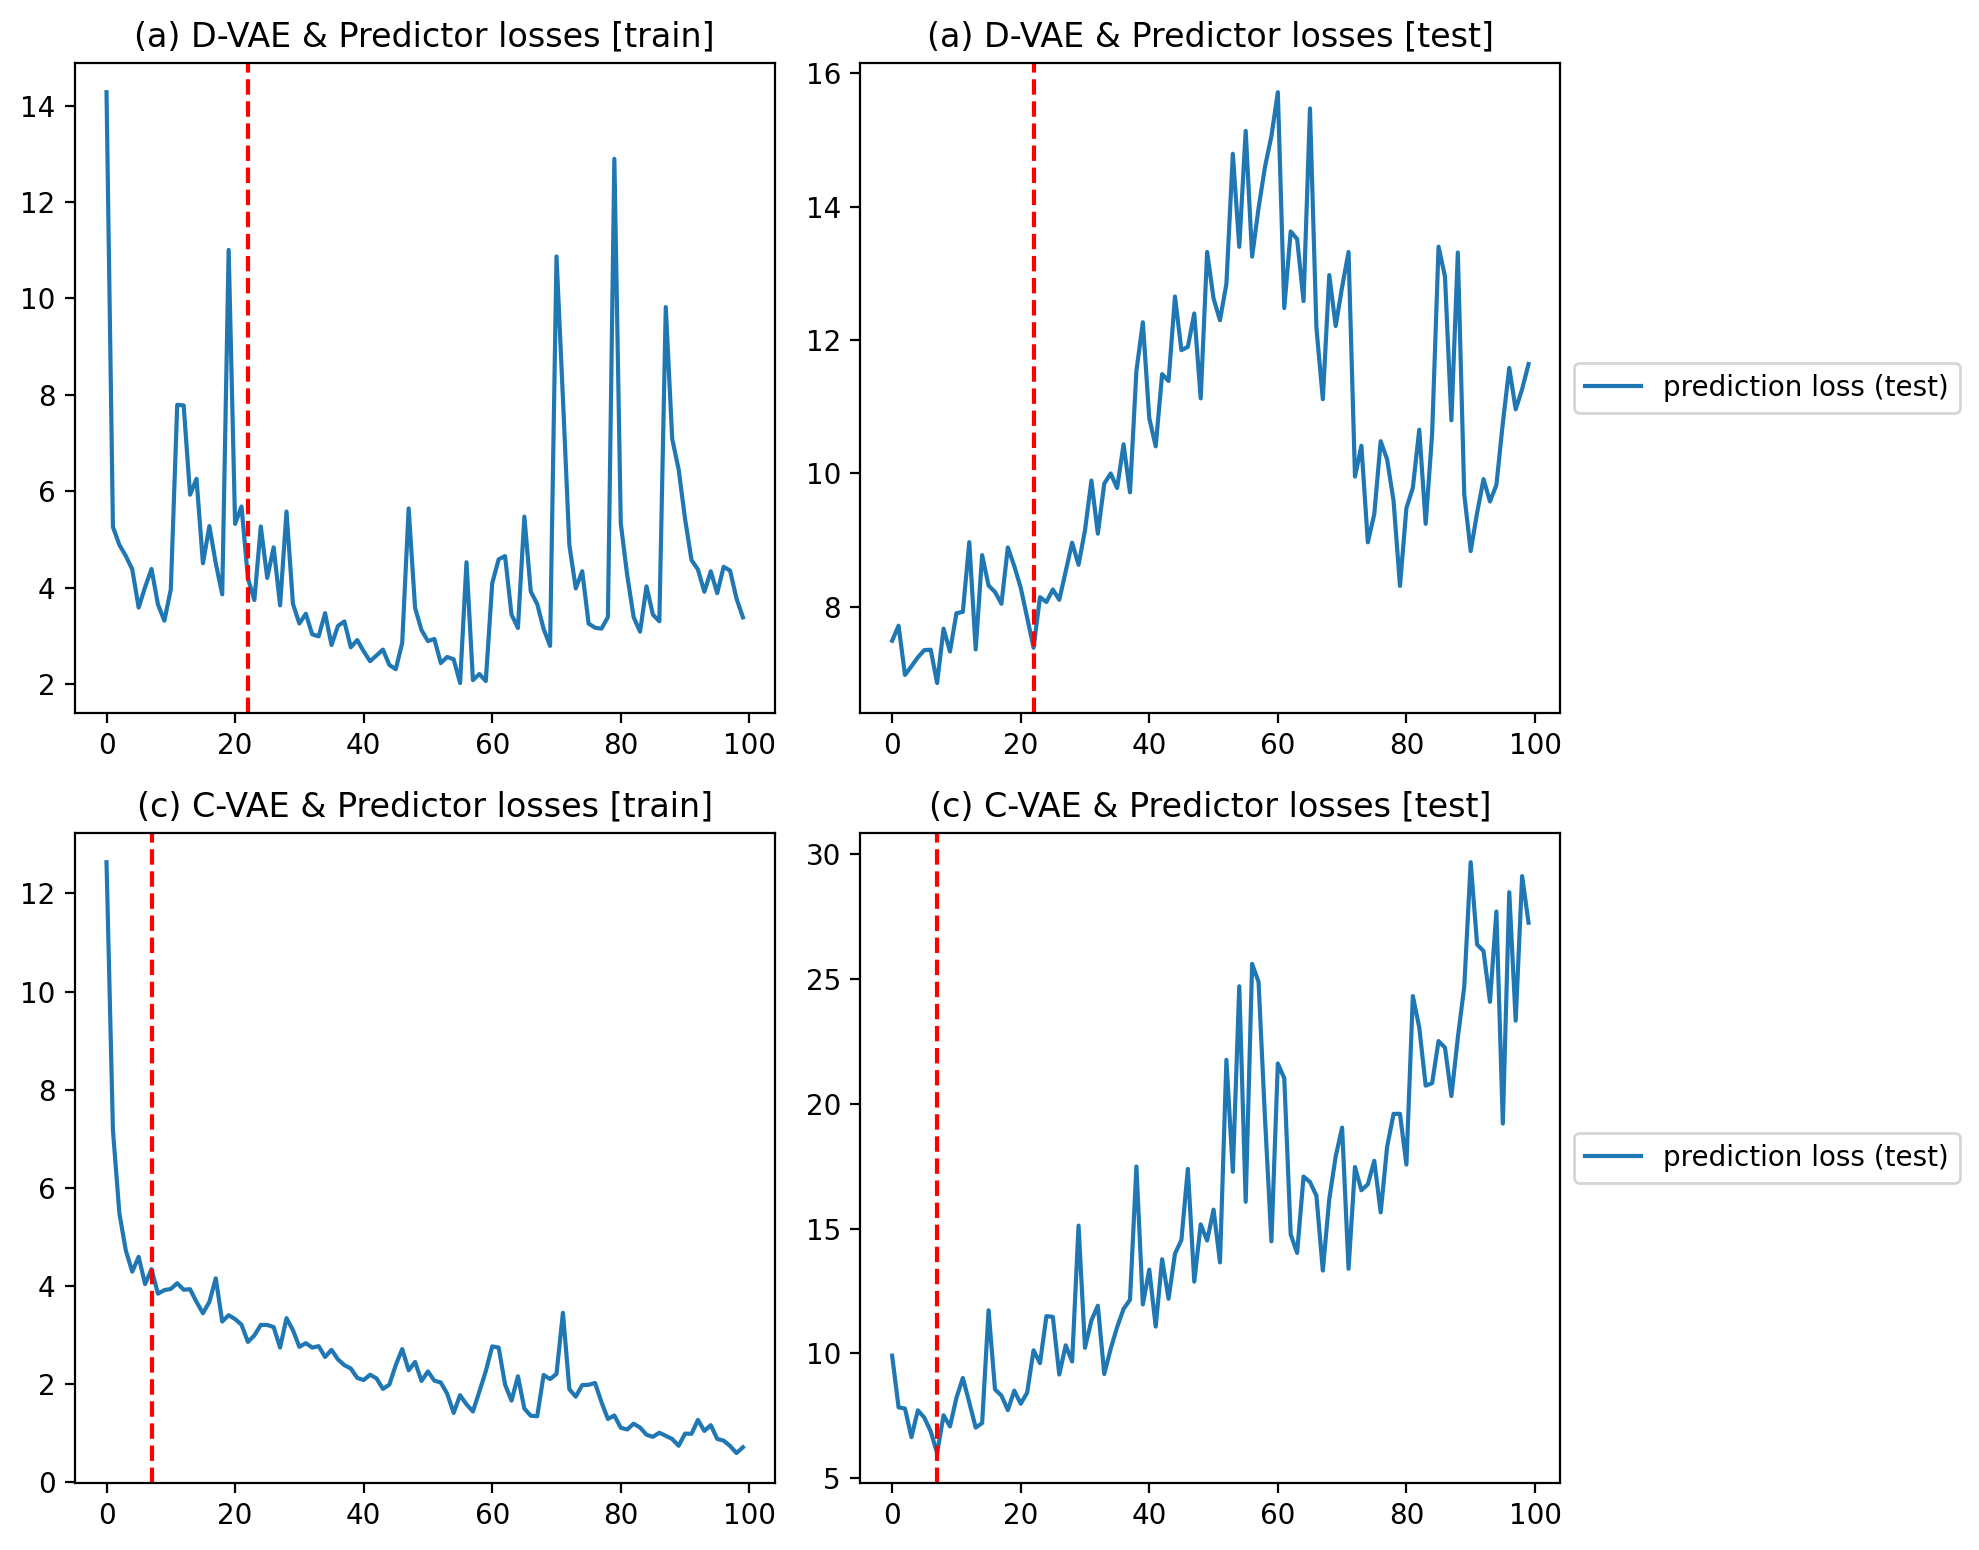

In [33]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_predict_training_losses_train_test_2cols(losses_train_hist_list[b][k], best_epoch_1round = best_epos_list[b][k])
        